In [ ]:

%load_ext autoreload
%autoreload 2
DATA_SEED = 613
MODEL_SEED = 26
LANGEVIN_SEED = 480
import juliacall
import os
import torch
import numpy as np
from dataclasses import dataclass, field
import sys
import scipy.stats as stats
from juliacall import Main as jl
jl.include('/home/akiva/FCNX-Ensembling/3layerexps/erfeigensolvers/FCS.jl')
sys.path.insert(0, '/home/akiva/FCNX-Ensembling')
torch.manual_seed(DATA_SEED)
torch.set_default_dtype(torch.float64)
DEVICE = torch.device('cuda:1')

from FCN3Network import FCN3NetworkEnsembleErf
from Experiment import Experiment, ExperimentLinear



experimentMF = Experiment(
    eps=0.03,
    file = '/home/akiva/exp/fcn3erf/erf_cubic_P_1600_D_40_N_256_epochs_40000000_lrA_6.25e-11_time_20251030_174053',
    N=256,
    d=40,
    chi=25,
    P=1600,
    ens=10
)

# experimentMFSmallD = Experiment(
#     eps=0.01,
#     file = '/home/akiva/exp/fcn3erf/erf_cubic_P_160_D_4_N_20_epochs_40000000_lrA_6.25e-10_time_20251103_125625',
#     N=20,
#     chi=25,
#     P=130,
#     ens=40,
#     d=4
# )

# experimentNNGP = Experiment(
#     eps=0.03,
#     file="/home/akiva/exp/fcn3erf/erf_cubic_P_130_D_25_N_250_epochs_2000000_lrA_7.69e-11_time_20251029_120218",
#     N=250,
#     d=25,
#     chi=1.0,
#     P=130,
#     ens=7
# )


# experimentMFSmallD.load()
experimentMF.load()

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Loaded model state_dict from /home/akiva/exp/fcn3erf/erf_cubic_P_1600_D_40_N_256_epochs_40000000_lrA_6.25e-11_time_20251030_174053/model.pth


In [26]:
experimentMF.model.device

device(type='cuda', index=1)

In [25]:
experimentMF.device

device(type='cuda', index=1)

In [28]:
X

(tensor([[ 0.77006924,  0.04592781,  1.12906688,  ..., -2.38052686,
           0.18014366, -1.00628110],
         [ 1.08964772, -1.07850944, -0.28632160,  ...,  1.20115351,
          -0.52785584,  0.21776657],
         [-0.44904999, -0.08947091, -0.17560791,  ...,  0.31493835,
          -0.57434055, -0.59053244],
         ...,
         [-0.55135486, -0.48351284,  0.42522110,  ...,  1.04380633,
           0.88831903, -0.49004521],
         [-0.37525028, -0.25315659, -0.33615447,  ..., -1.33396337,
          -0.52050706,  0.04124205],
         [-0.46917955, -0.62714169,  0.60827887,  ...,  0.97107626,
          -0.12476680, -0.37768353]], device='cuda:1'),
 (tensor([[ 0.77006924,  0.04592781,  1.12906688,  ..., -2.38052686,
            0.18014366, -1.00628110],
          [ 1.08964772, -1.07850944, -0.28632160,  ...,  1.20115351,
           -0.52785584,  0.21776657],
          [-0.44904999, -0.08947091, -0.17560791,  ...,  0.31493835,
           -0.57434055, -0.59053244],
          ...,
 

In [1]:
model = experimentMF.model
experimentMF.model.device = experimentMF.device
experimentMF.model.to(experimentMF.device)
X, _ = experimentMF.large_dataset(p_large=10_000, device = experimentMF.device)
experimentMF.model.H_eig_random_svd(X)


NameError: name 'experimentMF' is not defined

In [38]:
experimentMF.model = experimentMF.model.to(experimentMF.device)

In [ ]:
model = experimentMF.model
experimentMF.model.device = experimentMF.device
experimentMF.model.to(experimentMF.device)
experimentMF.X = experimentMF.X.to(experimentMF.device)
experimentMF.model.H_eig_random_svd(experimentMF.X)

In [40]:
h1 = experimentMF.model.h1_preactivation(experimentMF.X)


In [41]:
experimentMF.model.H_eig_random_svd(experimentMF.X)

IndexError: too many indices for tensor of dimension 1

In [3]:
torch.matmul(model(X_inf).squeeze().T, Y_inf).mean(dim=0) 

NameError: name 'model' is not defined

In [74]:
model = experimentMF.model.to(experimentMF.device)
P_inf = 5000
X_inf = torch.randn((P_inf, experimentMF.d),
                    dtype=torch.float64, device=experimentMF.device)
Y_inf = (X_inf**3 - 3 * X_inf)
P = Y_inf.squeeze().shape[0]
Y = X_inf # Y_inf.squeeze()
q = model.ens
# Shape of f is [P, 1, ens(q)]
f = model.h1_preactivation(X_inf)
f.shape
f = f[:, :, :]
K = torch.einsum('uiq,viq->uv', f, f).squeeze()/(P_inf * q * 30)
IyI2 = torch.einsum('ij,ij->j', Y.squeeze(), Y.squeeze())
λKs = torch.einsum('uj,uv,vj->j', Y, K, Y) / IyI2
μ = λKs / (λKs + 1 / experimentMF.P)
print("Target learnability: ", μ[0].item())
print("Perp learnability: ", μ[1:].mean().item())

Target learnability:  0.9946882013384033
Perp learnability:  0.9930662986004342


In [75]:
λKs

tensor([0.11703759, 0.08821757, 0.08754416, 0.08796945, 0.08603916, 0.09269311,
        0.08797050, 0.08740241, 0.08932624, 0.08843903, 0.08835670, 0.09114028,
        0.08365368, 0.09163742, 0.09308458, 0.08625831, 0.09073964, 0.08585865,
        0.08277602, 0.08799657, 0.09158442, 0.09232876, 0.08822182, 0.09731432,
        0.09311951, 0.08967944, 0.09267306, 0.08783870, 0.09808151, 0.08135141,
        0.09282113, 0.09181375, 0.09290031, 0.09050883, 0.09007898, 0.08311089,
        0.09334693, 0.09189537, 0.08995693, 0.09090960], device='cuda:1',
       grad_fn=<DivBackward0>)

In [49]:
experimentMF = Experiment(
    file='/home/akiva/exp/fcn3erf/erf_cubic_P_800_D_20_N_140_epochs_10000000_lrA_1.25e-10_time_20251104_172720',
    eps = 0.03,
    N = 140,
    P = 800, 
    d = 20, 
    chi = 1.0,
    ens = 20
)
experimentMF.load()

Loaded model state_dict from /home/akiva/exp/fcn3erf/erf_cubic_P_800_D_20_N_140_epochs_10000000_lrA_1.25e-10_time_20251104_172720/model.pth


In [103]:
experimentMF.d

40

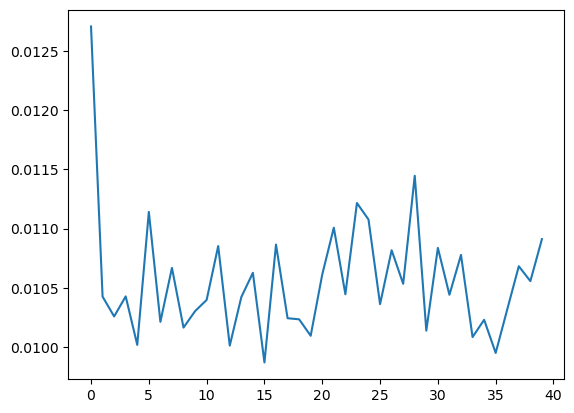

In [104]:
plt.plot(experimentMF.model.H_eig(X_inf, Y_inf).detach().cpu().numpy())

In [44]:
P_inf = 5000
X_inf = torch.randn((P_inf, experimentMF.d),
                    dtype=torch.float64, device=experimentMF.device)
Y_inf = X_inf#**3 - 3 * X_inf
f = experimentMF.model(X_inf)
phi = Y_inf / torch.linalg.norm(Y_inf, axis=0)
f_k = torch.einsum('uqi,ud->d',f, phi) / experimentMF.ens 
y_k = torch.einsum('ui, ui-> i', Y_inf, phi) 
learnabilities = (f_k / y_k).detach().cpu().numpy()
learnabilities


array([ 0.00789482, -0.00193016, -0.00553433, -0.00773191, -0.00110863,
        0.00635221,  0.00521943,  0.00040654,  0.00993235,  0.00259993,
        0.00346531,  0.00254192,  0.0020272 ,  0.00251492,  0.00446142,
        0.00368418,  0.0027531 , -0.00188046, -0.00352746,  0.00459316,
        0.00128663, -0.01110607,  0.00722992,  0.00449928,  0.0065092 ,
       -0.00559865,  0.00516027,  0.00142137,  0.00567605, -0.00259234,
        0.00163779, -0.00641702, -0.00653283,  0.01458102, -0.00428125,
        0.00357488,  0.00018226, -0.0027481 ,  0.00277181,  0.0009668 ])

In [90]:

lsT = experimentMF.predictions.to_list()[:4]
lsP = experimentMF.predictions.to_list()[4:]
lsT

[0.010479770001813136,
 4.259771142777658e-05,
 0.04405126536077733,
 4.284694204815319e-05]

In [94]:

muT1, muT = jl.FCS.compute_lK_ratio(
    lsT, experimentMF.P, experimentMF.N,experimentMF.chi, experimentMF.d, 1.0, 1.0, 0.03, 4 / (3 * torch.pi))

muP1, muP = jl.FCS.compute_lK_ratio(
    lsP, experimentMF.P, experimentMF.N, experimentMF.chi, experimentMF.d, 0.0, 1.0, 0.03, 4 / (3 * torch.pi))
muT, muP

(0.04349772975674351, 0.04636637645511283)

In [87]:
muT = muT1
muP = muP1
muP, muT

(0.9210670385312695, 0.9790593632286456)

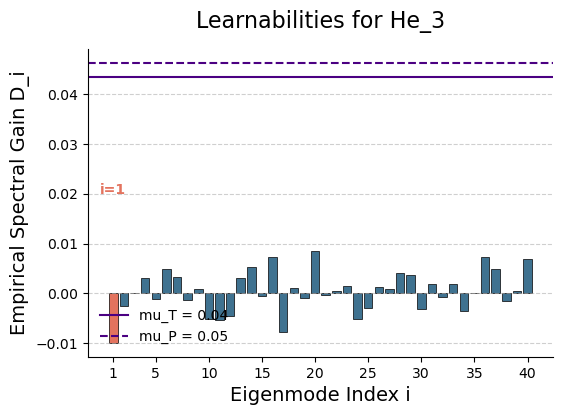

In [95]:
import matplotlib.pyplot as plt
# learnabilities = np.clip(learnabilities, 0.01, 0.99)  # Clip for stability
D = experimentMF.d



# =================================================================
# 2. PLOTTING CONFIGURATION (Strictly NO Mathtext)
# =================================================================

# Force text rendering using standard system fonts only
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "mathtext.fontset": "custom" # Use standard fonts, not the CM math fonts
})

# Define colors
COLOR_HIGHLIGHT = '#E3735E'
COLOR_NORMAL = '#3F7290'
COLOR_MU = '#4B0082' # Indigo or dark purple for the reference lines

# Create the color array
colors = [COLOR_HIGHLIGHT] + [COLOR_NORMAL] * (D - 1)
indices = np.arange(1, D + 1)

# =================================================================
# 3. GENERATE THE PLOT
# =================================================================

fig, ax = plt.subplots(figsize=(6, 4))

# Generate the bar plot
ax.bar(indices, learnabilities, color=colors,
       width=0.8, edgecolor='black', linewidth=0.5)

# --- ADD HORIZONTAL REFERENCE LINES ---
ax.axhline(muT, color=COLOR_MU, linestyle='-', linewidth=1.5, label=f'mu_T = {muT:.2f}')
ax.axhline(muP, color=COLOR_MU, linestyle='--', linewidth=1.5, label=f'mu_P = {muP:.2f}')


# 4. Formatting and Labels (Plain text only)

# Title (Plain text substitute for LaTeX formatting)
ax.set_title(
    f'Learnabilities for He_3', fontsize=16, pad=15)

# X-axis Label
ax.set_xlabel('Eigenmode Index i', fontsize=14)
# Set ticks
if D > 10:
    ax.set_xticks([1] + list(range(5, D + 1, 5)))
else:
    ax.set_xticks(indices)

# Y-axis Label (Plain text substitute)
ax.set_ylabel('Empirical Spectral Gain D_i', fontsize=14)
# ax.set_ylim(0, np.max([muT, muP]) * 1.5)

# Add grid lines
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Remove top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add a label to the first bar (Optional, plain text)
ax.text(indices[0], learnabilities[0] + 0.03, 'i=1',
        ha='center', color=COLOR_HIGHLIGHT, weight='bold', fontsize=10)

# Add Legend for the horizontal lines
ax.legend(loc='lower left', frameon=False) 

# plt.tight_layout()
plt.show()

In [20]:
model_out_flat = model_out.flatten()
gpr_pred_flat = Y_inf[:,0].flatten()
# Cosine similarity
cos_sim = torch.dot(model_out_flat, gpr_pred_flat) / (
                        torch.norm(model_out_flat) * torch.norm(gpr_pred_flat) + 1e-12)
cos_sim

tensor(0.9909, device='cuda:0', grad_fn=<DivBackward0>)

Is the distribution gaussian? Is our gaussianity assumption justified.

In [106]:
ept = Experiment(
    eps=0.03,
    file='/home/akiva/exp/fcn3erf/erf_cubic_P_160_D_4_N_20_epochs_40000000_lrA_6.25e-10_time_20251103_125625',
    N=15,
    chi=1.0,
    P=130,
    ens=10,
    d=10
)
mod = ept.model


def J_eig(X, Y1, Y2):
    print(mod.W0.shape)
    # J = torch.erf(contract('qkl,ul->uqk', mod.W0, X,
    #                 optimize=mod.forward_path_h0 if mod.forward_path_h0 is not None else None, backend='torch'))
    J = 2 / (torch.pi) * \
        torch.arcsin(contract('ui,vi->uv', X, X) / (3 * ept.d))
    J_k = contract('ul, uv, vl->l', Y1, J, Y2,
                    backend='torch') / contract('ul, ul->l', Y1, Y2)

    lJ = J_k / (X.shape[0])
    return lJ
device = torch.device('cuda:0')

def J_eig_batchwise(X_full, Y1_full, Y2_full, psi, batch_size=50):
    psi = int(psi)
    device = X_full.device

    num_batches = (psi + batch_size - 1) // batch_size
    total_lJ = torch.zeros(
        mod.d, dtype=torch.float64, device=device)
    for b in range(num_batches):
        start = b * batch_size
        end = min((b + 1) * batch_size, psi)
        X = X_full[start:end, :]
        Y1 = Y1_full[start:end, :]
        Y2 = Y2_full[start:end, :]

        # Compute J only for this batch
        J = 2 / (torch.pi) * torch.arcsin(
            contract('ui,vi->uv', X, X) / (3 * ept.d)
        )

        # Compute lJ contribution for the batch
        J_k = contract('ul, uv, vl->l', Y1, J, Y2, backend='torch') \
            / contract('ul, ul->l', Y1, Y2)
        # print(J_k)
        total_lJ += J_k / float(psi) / num_batches

    # Normalize by total number of samples (psi)
    return total_lJ 

from opt_einsum import contract
num_p = 20

p0 = 10_000_000
lg = 20_000_000
Xinf, Yinf = ept.large_dataset(device='cuda:0', p_large=lg)
X_inf = Xinf.to(torch.float64)
Y1_inf, Y3_inf = Yinf
Y1_inf = Y1_inf.to(torch.float64)
Y3_inf = Y3_inf.to(torch.float64)
ljs = torch.zeros(num_p)

batch_size = 5_000
Ps = torch.exp(torch.linspace(torch.log(torch.tensor(p0)),
                                    torch.log(torch.tensor(lg)),
                                    num_p))
Ps = Ps.to(torch.int64)

for i, psi in enumerate(Ps):
    _psi = int(psi.item())
    lJi = J_eig_batchwise(X_inf, Y1_inf, Y1_inf,
                          psi=_psi, batch_size=batch_size)
    ljs[i] = lJi.mean()

20000000 10


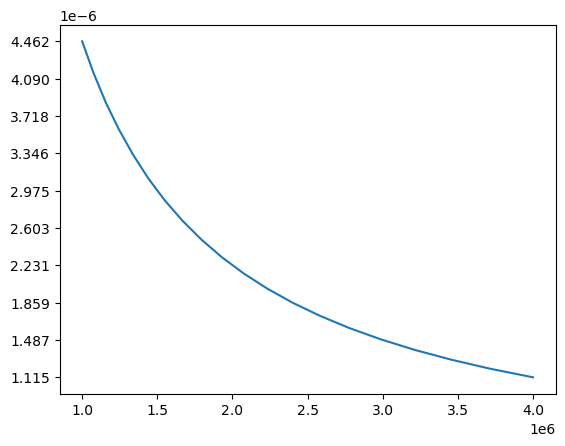

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(Ps, ljs)
# plt.yscale('log')

# Pick 10 y-values to show as labels
y_values = np.linspace(ljs.min(), ljs.max(), 10)
plt.yticks(y_values)          # Set the positions and labels to these 10 values
plt.show()

In [165]:
import torch
from opt_einsum import contract

ept = Experiment(
    eps=0.03,
    file='/home/akiva/exp/fcn3erf/erf_cubic_P_160_D_4_N_20_epochs_40000000_lrA_6.25e-10_time_20251103_125625',
    N=15,
    chi=1.0,
    P=130,
    ens=10,
    d=50
)
mod = ept.model
device = torch.device('cuda:0')


def J_dot_batch(X, v, batch_size=500):
    """Matrix-free multiplication J @ v in batches"""
    P, d = X.shape
    result = torch.zeros_like(v)
    for start in range(0, P, batch_size):
        end = min(start + batch_size, P)
        Xb = X[start:end]
        Jb = 2 / torch.pi * \
            torch.arcsin(contract('ui,vi->uv', Xb, X) / (3 * ept.d))
        result[start:end] = Jb @ v
    return result


def J_eig_batchwise_matrix_free(X_full, Y1_full, Y2_full, psi, batch_size=500):
    psi = int(psi)
    device = X_full.device

    # Take first psi samples
    X = X_full[:psi, :]
    Y1 = Y1_full[:psi, :]
    Y2 = Y2_full[:psi, :]

    # Orthonormalize columns along axis 0
    Q, _ = torch.linalg.qr(Y1)
    Y1_norm = Q

    # Compute projected lJ using matrix-free multiplication
    J_Y2 = torch.zeros_like(Y2)
    for col in range(Y2.shape[1]):
        J_Y2[:, col] = J_dot_batch(X, Y2[:, col], batch_size=batch_size)

    # lJ for each column
    numer = torch.einsum('ul,ul->l', Y1_norm, J_Y2)
    denom = torch.einsum('ul,ul->l', Y1_norm, Y2)
    lJ = numer / denom / psi
    return lJ


# --- Example usage ---
num_p = 20
p0 = 100_000
lg = 150_000
Xinf, Yinf = ept.large_dataset(device='cuda:0', p_large=lg)
X_inf = Xinf.to(torch.float64)
Y1_inf, Y3_inf = Yinf
Y1_inf = Y1_inf.to(torch.float64)
Y3_inf = Y3_inf.to(torch.float64)

ljs = torch.zeros(num_p)
batch_size = 1000
Ps = torch.exp(torch.linspace(torch.log(torch.tensor(p0)),
                              torch.log(torch.tensor(lg)),
                              num_p)).to(torch.int64)

for i, psi in enumerate(Ps):
    _psi = int(psi.item())
    lJi = J_eig_batchwise_matrix_free(X_inf, Y1_inf, Y1_inf,
                                      psi=_psi, batch_size=batch_size)
    ljs[i] = lJi.mean()

150000 50


KeyboardInterrupt: 

In [49]:
ept.eig_predictions()

Eigenvalues(lJ1T=0.0073991490145966995, lJ3T=1.4992578611102332e-05, lH1T=0.021832172015312415, lH3T=1.4992732632890467e-05, lJ1P=0.008488263631568477, lJ3P=2.2635369684180674e-05, lH1P=0.008488263631568477, lH3P=2.263536968418067e-05)

5000 50


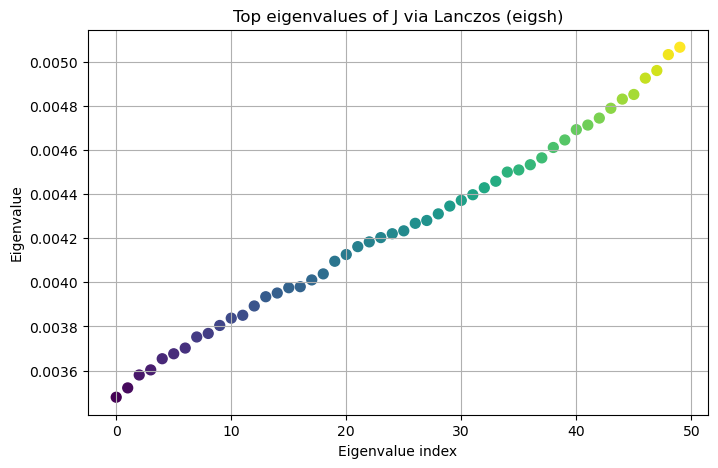

In [47]:
import torch
import matplotlib.pyplot as plt
from opt_einsum import contract
from scipy.sparse.linalg import eigsh  # Lanczos method for symmetric matrices

# --- Parameters ---
ept = Experiment(
    eps=0.03,
    file='/home/akiva/exp/fcn3erf/erf_cubic_P_160_D_4_N_20_epochs_40000000_lrA_6.25e-10_time_20251103_125625',
    N=15,
    chi=1.0,
    P=130,
    ens=10,
    d=50
)

# --- Load dataset ---
Xinf, Yinf = ept.large_dataset(device='cuda:0', p_large=5000)
Y1, Y3 = Yinf

# adjust d_basis, N_iter as needed
P, d, d_basis, N_iter = ept.P, ept.d, ept.d, 100
device = 'cpu'

# --- Prepare X and Y1 ---
X = Xinf[:, :].to(torch.float64)
Y1 = Y3[:, :d_basis].to(torch.float64)

# --- Orthonormalize Y1 columns ---
Q, _ = torch.linalg.qr(Y1)  # columns orthonormal
Y1_norm = Q

# --- Compute kernel matrix J ---
J = 2 / torch.pi * torch.arcsin(contract('ui,vi->uv', X, X) / (3 * ept.d))
J = J.cpu().numpy()  # convert to NumPy for scipy eigsh

# --- Use Lanczos (eigsh) to compute top d_basis eigenvalues ---
eigvals, eigvecs = eigsh(J, k=d_basis, which='LM')  # LM = largest magnitude

# --- Project onto Y1_norm (optional) to get Rayleigh quotients) ---
Y1_norm_np = Y1_norm.cpu().numpy()
proj_eigvals = np.einsum('ul,uv,vl->l', Y1_norm_np, J, Y1_norm_np)

# --- Plot top eigenvalues as “atomic spectrum” ---
plt.figure(figsize=(8, 5))
plt.scatter(range(len(eigvals)), eigvals / 5000, c=eigvals, cmap='viridis', s=50)
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
plt.title('Top eigenvalues of J via Lanczos (eigsh)')
plt.grid(True)
plt.show()

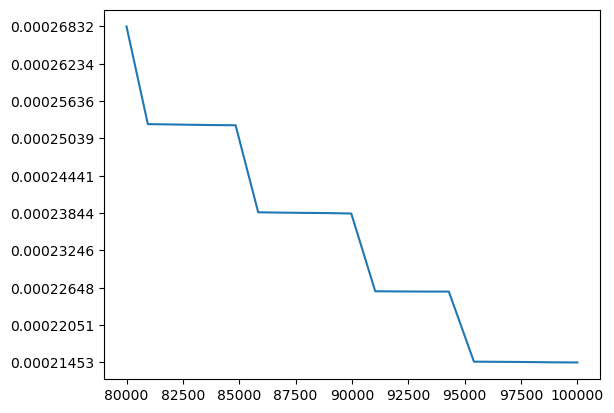

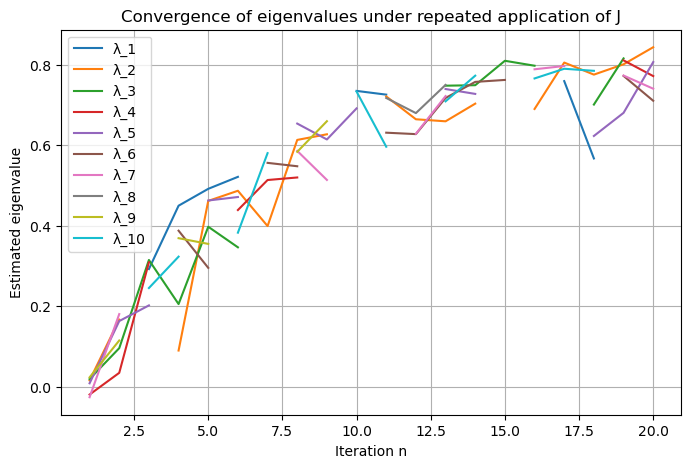

In [131]:
import torch
import matplotlib.pyplot as plt

# --- Parameters ---
P = 3000
d = 10        # number of basis vectors in Y3
N = 20        # number of iterations

# --- Example kernel matrix and Y3 ---
# For illustration, you can replace this with your actual J and Y3
torch.manual_seed(0)
J = torch.randn(P, P, dtype=torch.float64)
Y3 = torch.randn(P, d, dtype=torch.float64)

# --- Orthonormalize Y3 (columns) ---
Y3_norm, _ = torch.linalg.qr(Y3)

# --- Power-iteration to estimate eigenvalues ---
lJ_history = torch.zeros(N, d, dtype=torch.float64)
Z = Y3_norm.clone()
for n in range(N):
    Z = J @ Z
    Z = Z / torch.linalg.norm(Z, dim=0, keepdim=True)
    lJ_history[n] = (Y3_norm.T @ Z).diag() ** (1 / (n+1))

# --- Plot convergence of each eigenvalue ---
plt.figure(figsize=(8, 5))
for k in range(d):
    plt.plot(range(1, N+1), lJ_history[:, k], label=f'λ_{k+1}')
plt.xlabel('Iteration n')
plt.ylabel('Estimated eigenvalue')
plt.title('Convergence of eigenvalues under repeated application of J')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
from opt_einsum import contract

# Experiment object
ept = Experiment(
    eps=0.03,
    file='/home/akiva/exp/fcn3erf/erf_cubic_P_160_D_4_N_20_epochs_40000000_lrA_6.25e-10_time_20251103_125625',
    N=15,
    chi=1.0,
    P=130,
    ens=10,
    d=100
)
mod = ept.model

# Set size
lg = 5000
device = torch.device('cpu')  # change to 'cuda' if needed

# Load dataset
Xinf, Yinf = ept.large_dataset(device=device, p_large=lg)
X = Xinf.to(torch.float64)
Y1, Y3 = [y.to(torch.float64) for y in Yinf]

# Compute J matrix
J = 2 / torch.pi * torch.arcsin(contract('ui,vi->uv', X, X) / (3 * ept.d))
print("Shape of J:", J.shape)

# Compute eigenvalues
eigvals = torch.linalg.eigvals(J)  # complex if necessary
# If eigenvalues are complex, take real part (or abs) depending on context
eigvals = eigvals.real  

# Normalize by <Y1|Y2>
norm_factor = contract('ul,ul->l', Y1, Y3)  # this gives vector of norms per component
lJ = eigvals / norm_factor.mean()  # normalize eigenvalues by the average norm

print("Shape of lJ:", lJ.shape)
print("Mean lJ:", lJ.mean())
print("First 5 normalized eigenvalues:", lJ[:5])


5000 100
Shape of J: torch.Size([5000, 5000])
Shape of lJ: torch.Size([5000])
Mean lJ: tensor(0.0061)
First 5 normalized eigenvalues: tensor([0.3826, 0.3782, 0.3742, 0.3717, 0.3704])


In [92]:
Y3.T @ Y3

tensor([[ 2.9986e+04, -7.5495e+01,  5.9271e+02,  ..., -1.2006e+02,
         -2.9139e+02,  2.9103e+02],
        [-7.5495e+01,  2.8767e+04,  1.8254e+02,  ..., -2.0762e+02,
         -2.1670e+02,  1.4136e+02],
        [ 5.9271e+02,  1.8254e+02,  2.8070e+04,  ...,  4.0345e+02,
         -4.8557e+02, -3.8823e+02],
        ...,
        [-1.2006e+02, -2.0762e+02,  4.0345e+02,  ...,  2.4816e+04,
         -3.3815e+02, -1.8048e+01],
        [-2.9139e+02, -2.1670e+02, -4.8557e+02,  ..., -3.3815e+02,
          3.1559e+04,  5.3745e+02],
        [ 2.9103e+02,  1.4136e+02, -3.8823e+02,  ..., -1.8048e+01,
          5.3745e+02,  2.8507e+04]])

In [ ]:
Y1 @ 

torch.Size([40000, 100])

In [121]:
import torch
import matplotlib.pyplot as plt
from opt_einsum import contract

# --- Load your experiment and data ---
ept = Experiment(
    eps=0.03,
    file='/home/akiva/exp/fcn3erf/erf_cubic_P_160_D_4_N_20_epochs_40000000_lrA_6.25e-10_time_20251103_125625',
    N=15,
    chi=1.0,
    P=130,
    ens=10,
    d=100
)
mod = ept.model
lg = 5000
device = torch.device('cpu')  # or 'cuda'

Xinf, Yinf = ept.large_dataset(device=device, p_large=lg)
X = Xinf.to(torch.float64)
Y1, Y3 = [y.to(torch.float64) for y in Yinf]

# --- Compute J ---
J = 2 / torch.pi * torch.arcsin(contract('ui,vi->uv', X, X) / (3 * ept.d))

# --- Orthonormalize Y1 along axis 0 (rows) ---
Q, _ = torch.linalg.qr(Y1)  # columns of Y1.T are rows of Y1
Y1_orth = Q
Y1_orth.shape

5000 100


torch.Size([5000, 100])

In [122]:
(Y1.T @ Y1).diag().shape

torch.Size([100])

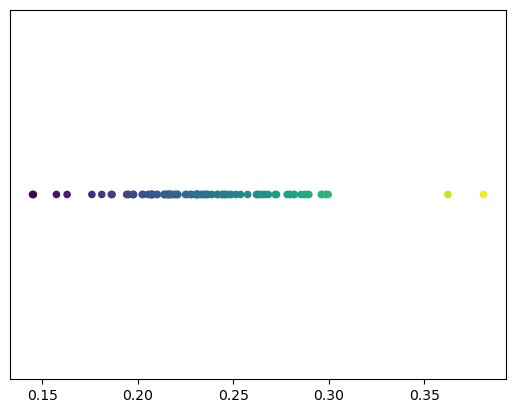

In [123]:


# --- Compute Rayleigh quotients <Y1_orth | J | Y1_orth> ---
lJ = torch.einsum('ul,uv,vl->l', Y3, J, Y3) / (Y3.T @ Y3).diag()

# --- Plot as horizontal atomic spectrum ---
plt.scatter(lJ, torch.zeros_like(lJ), c=lJ, cmap='viridis', s=20)
plt.gca().get_yaxis().set_visible(False)
plt.show()

In [88]:
# check normalization
v = torch.eye(B.shape[0], dtype=B.dtype)
eigvals_check = torch.diagonal(v.T @ A @ v) / torch.diagonal(v.T @ B @ v)
eigvals_check

tensor([0.1978, 0.1760, 0.1449, 0.2077, 0.2149, 0.2797, 0.2285, 0.2204, 0.2629,
        0.2277, 0.2163, 0.2659, 0.2080, 0.2029, 0.2416, 0.2180, 0.2820, 0.2101,
        0.2966, 0.2356, 0.2055, 0.2464, 0.2070, 0.1949, 0.1453, 0.1574, 0.1862,
        0.2348, 0.2417, 0.2317, 0.1942, 0.2628, 0.2388, 0.2368, 0.2068, 0.2276,
        0.1630, 0.2065, 0.2331, 0.2101, 0.2357, 0.2489, 0.2209, 0.1952, 0.2962,
        0.2514, 0.2818, 0.2302, 0.2684, 0.2209, 0.2988, 0.2166, 0.1973, 0.2888,
        0.2361, 0.2155, 0.2312, 0.2074, 0.2576, 0.2161, 0.2315, 0.2196, 0.3624,
        0.2250, 0.2442, 0.2457, 0.2622, 0.2480, 0.1976, 0.2896, 0.2856, 0.2538,
        0.2720, 0.2998, 0.2177, 0.2023, 0.1866, 0.2795, 0.2726, 0.2160, 0.2255,
        0.2139, 0.2173, 0.2336, 0.2308, 0.2644, 0.2463, 0.2451, 0.2306, 0.2194,
        0.2138, 0.2313, 0.2985, 0.2874, 0.3810, 0.2782, 0.2669, 0.2140, 0.2442,
        0.1811])

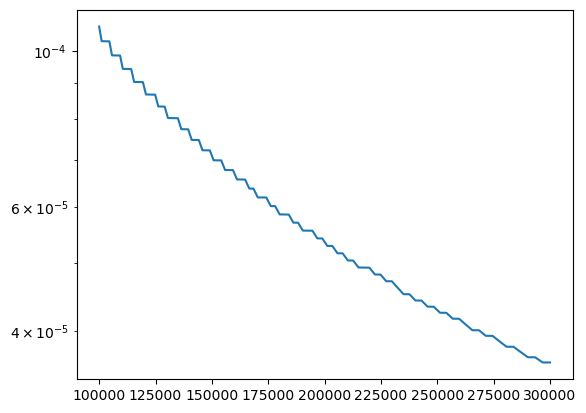

<BarContainer object of 100 artists>

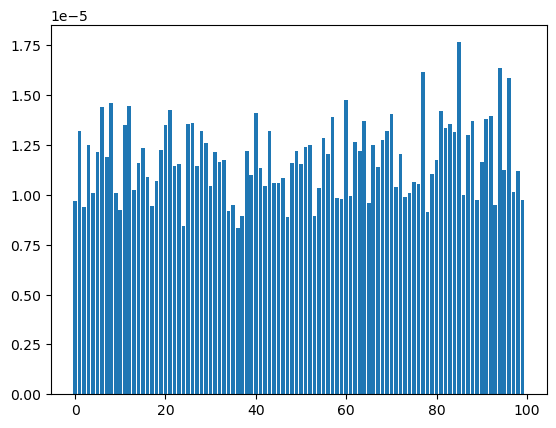

In [120]:
import matplotlib.pyplot as plt
y = lJ.detach().numpy().tolist()
x = list(range(len(y)))
plt.bar(x, y)

In [121]:
torch.mean(lJ)

tensor(1.1793e-05)

tensor(4.8812e-06, grad_fn=<StdBackward0>)

In [8]:
mod.H_eig(Xinf, Y3_inf)

tensor([0.0003, 0.0003, 0.0005, 0.0006, 0.0006, 0.0004, 0.0004, 0.0005, 0.0005,
        0.0006, 0.0005, 0.0004, 0.0005, 0.0003, 0.0006, 0.0006, 0.0005, 0.0004,
        0.0005, 0.0005, 0.0005, 0.0006, 0.0004, 0.0009, 0.0004, 0.0005, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0003, 0.0006, 0.0007, 0.0007, 0.0010, 0.0005,
        0.0015, 0.0006, 0.0006, 0.0005])

In [44]:
a = np.array([4.2162e-05, 5.9283e-05, 4.2345e-05, 4.0770e-05, 4.2545e-05, 5.3662e-05,
                3.8438e-05, 9.2072e-05, 5.1106e-05, 5.3914e-05, 4.8491e-05, 5.3164e-05,
                5.5923e-05, 4.0868e-05, 5.6450e-05, 4.1556e-05, 6.9984e-05, 7.3592e-05,
                9.5481e-05, 5.8494e-05, 5.2370e-05, 5.3775e-05, 7.5838e-05, 5.9072e-05,
                5.5453e-05, 4.7211e-05, 7.3614e-05, 4.2853e-05, 3.7023e-05, 4.4833e-05,
                5.6749e-05, 5.6082e-05, 6.5529e-05, 1.1107e-04, 4.3403e-05, 4.5572e-05,
                5.1702e-05, 4.9638e-05, 7.9490e-05, 4.1322e-05])
np.mean(a)

5.6322475e-05

In [30]:
predictions = experimentMF.eig_predictions()

In [31]:

i0 = np.array([0.01, 1.0e-5, 0.04, 1.e-5])
χ = experimentMF.chi
d = experimentMF.d
n = experimentMF.N
ϵ = experimentMF.eps
π = np.pi
δ = float(1.0)
P = experimentMF.P
lr = float(1.0e-6)
Tf = 6000000

lT = jl.FCS.nlsolve_solver(
    juliacall.convert( jl.Vector[jl.Float64], i0),
    chi=χ, d=d, kappa=1.0, delta=δ,
    epsilon=ϵ, n=n, b=4 / (3 * π),
    P=P, lr=lr, max_iter=Tf, verbose=False, anneal=True
)
δ = 0.0
lP = jl.FCS.nlsolve_solver(
    juliacall.convert(jl.Vector[jl.Float64], i0),
    chi=χ, d=d, kappa=1.0, delta=δ,
    epsilon=ϵ, n=n, b=4 / (3 * π),
    P=P, lr=lr, max_iter=Tf, verbose=False, anneal=True
)
print("Target Eigenvalues: ")
print(f"lH1: {lT[2]: 0.6f} lH3: {lT[3]: 0.6f} lJ1: {lT[0]: 0.6f} lJ3: {lT[1]:0.6f}")
print("Perpendicular Eigenvalues: ")
print(f"lH1: {lP[2]: 0.6f} lH3: {lP[3]: 0.6f} lJ1: {lP[0]: 0.6f} lJ3: {lP[1]: 0.6f}")

Target Eigenvalues: 
lH1:  0.133272 lH3:  0.000040 lJ1:  0.010114 lJ3: 0.000038
Perpendicular Eigenvalues: 
lH1:  0.010610 lH3:  0.000044 lJ1:  0.010610 lJ3:  0.000044


In [32]:
predictions

Eigenvalues(lJ1T=0.010114047402768007, lJ3T=3.8291816355661954e-05, lH1T=0.13327242512064333, lH3T=4.028930572721747e-05, lJ1P=0.01061032953951653, lJ3P=4.420970647797673e-05, lH1P=0.010610329539618948, lH3P=4.4209706592496234e-05)

In [33]:
jl.FCS.compute_lK_ratio(lT, P, n, χ, d, 1.0, 1.0, 1.0, 4 / (3 * π))

(0.9923305782933849, 0.037642601359943975)

In [38]:
t = experimentMF.model.W0[:,:,0].detach().cpu()
k1 = stats.kstat(t, n=1)  # 1st cumulant estimator (mean): 2.5
k2 = stats.kstat(t, n=2)  # 2nd (unbiased variance): ≈1.6667
k3 = stats.kstat(t, n=3)  # 3rd: 0.0
k4 = stats.kstat(t, n=4)  # 4th: ≈-3.3333

print("Cumulants")
print(f"  k1: {k1}")
print(f"  k2: {k2}")
print(f"  k3: {k3}")
print(f"  k4: {k4}")

Cumulants
  k1: 0.008141882225637586
  k2: 0.031423185270387816
  k3: -0.000893996503549296
  k4: -0.0004660384180123367


According to these numbers, yes we are not gaussian

In [39]:
t = experimentMF.model.W0[:, :, 1:].detach().cpu()
k1 = stats.kstat(t, n=1)  # 1st cumulant estimator (mean): 2.5
k2 = stats.kstat(t, n=2)  # 2nd (unbiased variance): ≈1.6667
k3 = stats.kstat(t, n=3)  # 3rd: 0.0
k4 = stats.kstat(t, n=4)  # 4th: ≈-3.3333

print("Cumulants")
print(f"  k1: {k1}")
print(f"  k2: {k2}")
print(f"  k3: {k3}")
print(f"  k4: {k4}")

Cumulants
  k1: -0.0007024451328069107
  k2: 0.025296201369771117
  k3: -4.667074553372488e-05
  k4: -2.6865218041449006e-05


---------------(((( MF Exp ))))------------


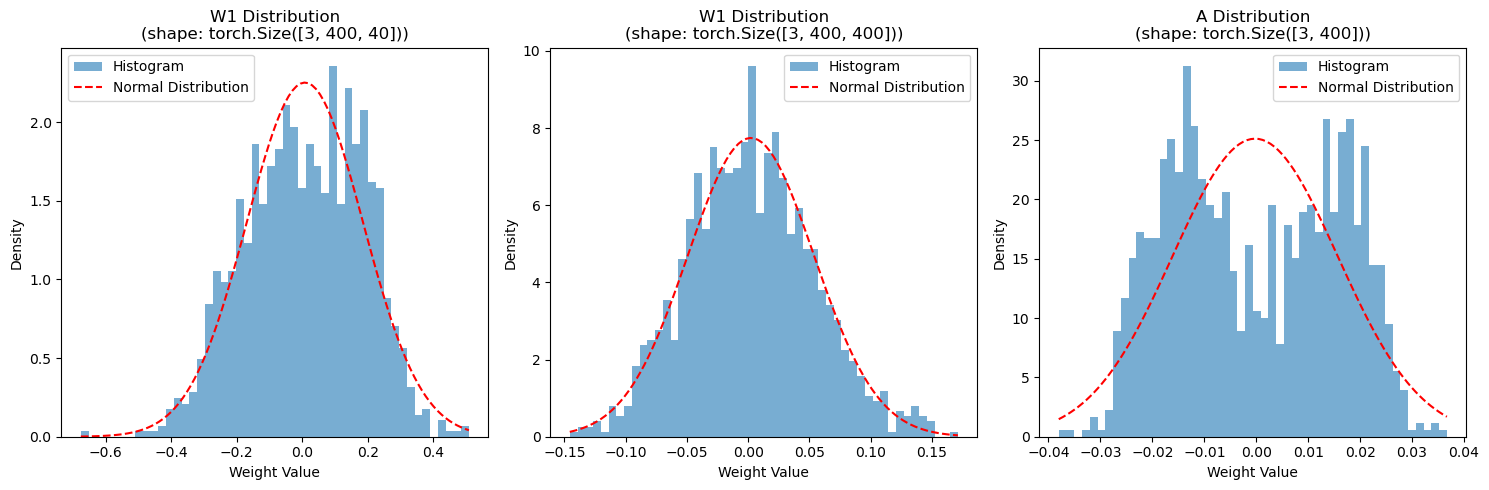


Summary Statistics:

W0 Targ:
Mean: 0.008142
Std: 0.177192
Skewness: -0.160294
Kurtosis: -0.475009

W1 Perp:
Mean: 0.002213
Std: 0.051522
Skewness: 0.170434
Kurtosis: -0.046056

A:
Mean: -0.000222
Std: 0.015879
Skewness: 0.040629
Kurtosis: -1.238932

Shapiro-Wilk Test (p-value):
W0: 0.000001
W1: 0.047980
A:  0.000000
---------------(((( SSC Exp ))))------------


NameError: name 'experimentNNGP' is not defined

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def gaussianity_test(experiment):
    model = experiment.model
    # Set up the figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Helper function to plot histogram and normal curve
    def plot_distribution(ax, data, title):
        # Plot histogram
        counts, bins, _ = ax.hist(data, bins=50, density=True, alpha=0.6, label='Histogram')
        
        # Fit and plot normal distribution
        mu, sigma = np.mean(data), np.std(data)
        x = np.linspace(min(bins), max(bins), 100)
        norm_curve = stats.norm.pdf(x, mu, sigma)
        ax.plot(x, norm_curve, 'r--', label='Normal Distribution')
        
        ax.set_title(title)
        ax.set_xlabel('Weight Value')
        ax.set_ylabel('Density')
        ax.legend()


    # Plot W0 distribution
    w0_flat = model.W0[:, :, 0].detach().cpu().numpy().flatten()
    plot_distribution(
        ax1, w0_flat, f'W1 Distribution\n(shape: {model.W0.shape})')

    # Plot W1 distribution
    w1_flat = model.W1[:, :, 0].detach().cpu().numpy().flatten()
    plot_distribution(
        ax2, w1_flat, f'W1 Distribution\n(shape: {model.W1.shape})')

    # Plot A distribution
    a_flat = model.A.detach().cpu().numpy().flatten()
    plot_distribution(ax3, a_flat, f'A Distribution\n(shape: {model.A.shape})')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nSummary Statistics:")
    print("\nW0 Targ:")
    print(f"Mean: {np.mean(w0_flat):.6f}")
    print(f"Std: {np.std(w0_flat):.6f}")
    print(f"Skewness: {stats.skew(w0_flat):.6f}")
    print(f"Kurtosis: {stats.kurtosis(w0_flat):.6f}")

    print("\nW1 Perp:")
    print(f"Mean: {np.mean(w1_flat):.6f}")
    print(f"Std: {np.std(w1_flat):.6f}")
    print(f"Skewness: {stats.skew(w1_flat):.6f}")
    print(f"Kurtosis: {stats.kurtosis(w1_flat):.6f}")

    print("\nA:")
    print(f"Mean: {np.mean(a_flat):.6f}")
    print(f"Std: {np.std(a_flat):.6f}")
    print(f"Skewness: {stats.skew(a_flat):.6f}")
    print(f"Kurtosis: {stats.kurtosis(a_flat):.6f}")

    # Add Shapiro-Wilk test for normality
    print("\nShapiro-Wilk Test (p-value):")
    print(f"W0: {stats.shapiro(w0_flat)[1]:.6f}")
    print(f"W1: {stats.shapiro(w1_flat)[1]:.6f}")
    print(f"A:  {stats.shapiro(a_flat)[1]:.6f}")

print("---------------(((( MF Exp ))))------------")
gaussianity_test(experimentMF)
print("---------------(((( SSC Exp ))))------------")
gaussianity_test(experimentNNGP)

In [ ]:
model = experimentMF.model

In [ ]:
def plot_distribution(ax, data, title):
    # Plot histogram
    counts, bins, _ = ax.hist(data, bins=40, density=True, alpha=0.6, label='Histogram')
    
    # Fit and plot normal distribution
    mu, sigma = np.mean(data), np.std(data)
    x = np.linspace(min(bins), max(bins), 40)
    norm_curve = stats.norm.pdf(x, mu, sigma)
    ax.plot(x, norm_curve, 'r--', label='Normal Distribution')
    
    ax.set_title(title)
    ax.set_xlabel('Weight Value')
    ax.set_ylabel('Density')
    ax.legend()


In [ ]:
np.mean(model.W0.detach().cpu().numpy()[:, :, 0].flatten())

0.003955217928619953

In [ ]:
np.mean(model.W0.detach().cpu().numpy()[:, :, 1:].flatten())

0.0005105941633795118

NameError: name 'plot_distribution' is not defined

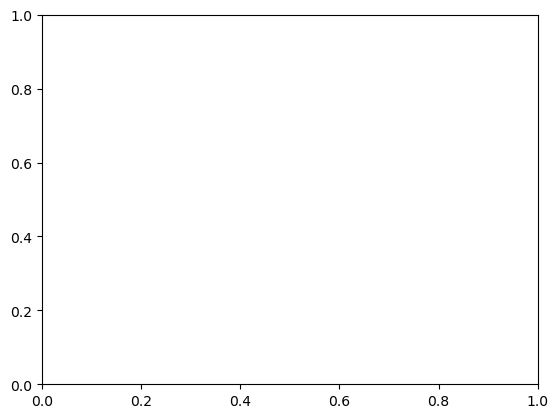

In [ ]:

fig, ax = plt.subplots()
plot_distribution(ax, model.W0.detach().cpu().numpy()[:, :,0].flatten(), 'W0 Target Dist')

In [ ]:
def covariance_over_k_averaged(W: torch.Tensor) -> torch.Tensor:
    """
    Parameters
    ----------
    W : torch.Tensor
        Tensor of shape (I, J, K).  `i` = 0..I-1, `j` = 0..J-1, `k` = 0..K-1.

    Returns
    -------
    torch.Tensor
        A (K, K) covariance matrix obtained by:
          1. For every (i,j) compute cov(W[i,j,:])
          2. Average those (I*J) covariance matrices.
    """
    I, J, K = W.shape

    # 1. Reshape so that each (i,j) is a separate "sample"
    #    -> shape (I*J, K)
    X = W.reshape(I * J, K)                # (N, K)  with N = I*J

    # 2. Center the data (subtract column means)
    X_centered = X - X.mean(dim=1, keepdim=True)   # (N, K)

    # 3. Compute the (biased) covariance for each sample separately
    #    cov_per_sample = (1/K) * X_centered.T @ X_centered   would be the *global* cov
    #    Instead we need the per-sample cov and then average them:
    #    cov_ij = (1/(K-1)) * X_centered[n:n+1].T @ X_centered[n:n+1]
    #    (the 1/(K-1) is the unbiased estimator for a single vector)

    # Vectorized per-sample outer product:
    #    (N, K, 1) @ (N, 1, K)  ->  (N, K, K)
    outer = X_centered.unsqueeze(-1) * X_centered.unsqueeze(-2)   # (N, K, K)

    # Unbiased covariance for a single vector of length K:
    cov_per_ij = outer / (K - 1)                                 # (N, K, K)

    # 4. Average over all (i,j) pairs
    cov_avg = cov_per_ij.mean(dim=0)                            # (K, K)

    return cov_avg

# cov_avg = covariance_over_k_averaged(model.W1).detach().cpu().numpy()


In [ ]:
model = experimentMF.model
import matplotlib.pyplot as plt

<BarContainer object of 40 artists>

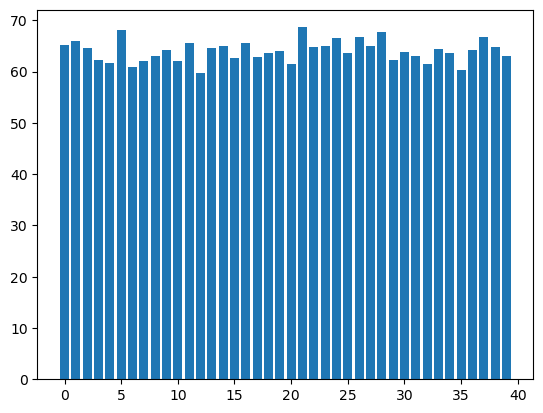

In [ ]:
Σ_W0 = torch.einsum('qim, qim-> m', model.W0, model.W0).detach().cpu().numpy()
plt.bar(range(Σ_W0.shape[0]), Σ_W0)

In [ ]:
ens

NameError: name 'ens' is not defined

In [78]:
#model = experimentMF.model.to('cuda:0')

experimentMF.device = 'cpu'
experimentMF.model.to(torch.device('cpu'))

X_inf, Yinf = experimentMF.large_dataset(p_large=2000,device='cpu')
Y1_inf, Y3_inf = Yinf
Y3_inf = Y3_inf / 6**0.5
kappa = 1.0
Y = Y1_inf
X = X_inf


def λKs(expr, X, Y, l='h1', std = False, a = 1.0, mux = None):
    """
    a: The orthogonality scale <g,Kg> = a*<g,g>
    """
    with torch.no_grad():
        g = {
            'k': lambda x: torch.transpose(expr.model(x), 1,2),
            'h1': expr.model.h1_preactivation
        }
        model = expr.model

        N = expr.N
        P = X.shape[0]
        # Kernel is averaged over ensemble and neuron indices
        f_inf = g[l](X)

        #f_inf: P * ens * N
        # Implicitly summing over N to obtain P * P * ens
        hh_inf_i = torch.einsum('uim,vim->uvi', f_inf, f_inf)/ (N * P)
        # Summing over ensembles
        hh_inf = torch.sum(hh_inf_i, axis=2) / (expr.ens) # Sample covariance

        norm = torch.einsum('ij,ij->j', Y.squeeze(), Y.squeeze()) / P

        # Ens * d
        Ls_i = torch.einsum('uj,uvi,vj->ij', Y.squeeze(), 
                            hh_inf_i, Y.squeeze()) / P
        lsT_i = Ls_i/norm


        std_ls = torch.std(lsT_i, axis=0).detach().cpu().numpy()


        # Large matrix projection
        Ls = torch.einsum('uj,uv,vj->j', Y.squeeze(), 
                        hh_inf, Y.squeeze()) / P


        lsT = Ls/norm
        lsT = lsT.detach().cpu().numpy()
        if not std: 
            return lsT
        else:
            return lsT, std_ls

def l_ratio(expr, ls):
    return ls / (ls + kappa/expr.P)

def eigs(expr, X, Y1, Y3):
    mux = None #torch.exp(-torch.linalg.norm(X, axis=1)/2) * 1/(2*torch.pi)**X.shape[1]
    λH1,σλH1  = λKs(expr, X, Y1, l='h1', std=True)
    λH3, σλH3 = λKs(expr, X, Y3, l='h1', std=True)
    return {
        'λH1': λH1,
        'σλH1': σλH1, 
        'λH3': λH3,
        'σλH3': σλH3
    }

def learnabilities(exp, X_inf, Y1_inf, Y3_inf):
    mux = None #torch.exp(-torch.linalg.norm(X, axis=1)/2)

    l1 = l_ratio(exp, exp.model.K_eig(X_inf, Y1_inf))
    l3 = l_ratio(exp, exp.model.K_eig(X_inf, Y3_inf))
    return {
        "μ_He1": l1,
        "μ_He3": l3
    }
eigdict = eigs(experimentMF, X_inf, Y1_inf, Y3_inf)
eigdict

{'λH1': array([0.01436881, 0.01049872, 0.00981152, 0.01015469, 0.0102812 ,
        0.01082658, 0.01020761, 0.01088233, 0.01083312, 0.01041827,
        0.0111496 , 0.01043792, 0.0098751 , 0.01090674, 0.01107039,
        0.01043303, 0.01113751, 0.01079785, 0.01063088, 0.01084033,
        0.01083819, 0.01104726, 0.01058301, 0.01086573, 0.01139015,
        0.00975815, 0.01056384, 0.01106176, 0.01187282, 0.00952194,
        0.01066617, 0.01054202, 0.0112175 , 0.01024619, 0.01093081,
        0.00970884, 0.01003364, 0.01143784, 0.01106054, 0.01079427]),
 'σλH1': array([0.00176139, 0.00123277, 0.00123048, 0.00117385, 0.00119461,
        0.00123295, 0.00102599, 0.00141937, 0.00149623, 0.00070238,
        0.00134645, 0.0011208 , 0.00102511, 0.00153444, 0.00154079,
        0.00116292, 0.00086971, 0.00075467, 0.00128518, 0.00133664,
        0.00145619, 0.00091206, 0.00133768, 0.00129084, 0.00125744,
        0.00109964, 0.00093389, 0.00162041, 0.00141684, 0.0010037 ,
        0.00096286, 0.00144726,

In [105]:
f = torch.transpose(experimentMF.model(X_inf), 1, 2)
f.shape

torch.Size([1000, 10, 1])

In [106]:
experimentMF.model.h1_activation(X).shape

torch.Size([1000, 10, 256])

In [129]:
lKs = experimentMF.model.K_eig(X_inf, Y3_inf, a = 1 / 6.0)
lKs

tensor([1.4621e-03, 5.2382e-05, 3.4153e-05, 5.7330e-04, 2.4940e-04, 2.5725e-04,
        1.8163e-04, 5.8239e-05, 4.2624e-05, 2.7508e-05, 4.3913e-05, 6.3791e-05,
        1.4062e-04, 9.3617e-05, 1.2321e-03, 7.6663e-05, 6.1931e-05, 3.6289e-04,
        5.1844e-04, 6.5470e-04, 7.3234e-05, 1.1206e-04, 5.4694e-05, 1.3480e-04,
        7.6148e-05, 9.6579e-05, 3.4992e-04, 5.2629e-05, 1.0258e-04, 9.9596e-05,
        6.2522e-05, 1.0231e-03, 5.0033e-05, 4.8359e-04, 1.2924e-03, 2.3111e-05,
        3.9491e-04, 6.1495e-04, 1.0150e-04, 1.0407e-04],
       grad_fn=<DivBackward0>)

In [108]:
λKs(experimentMF, X_inf, Y3_inf, l='k', a=6.0)

array([3.85819619e-10, 9.42126610e-10, 4.50598742e-10, 2.45312718e-10,
       6.27441960e-10, 8.29958012e-10, 8.47808502e-10, 6.57840765e-10,
       1.52355346e-09, 4.28899638e-10, 9.44630718e-10, 3.85629636e-10,
       5.95405777e-10, 9.37643311e-10, 4.39938757e-10, 8.39356593e-10,
       2.85237433e-10, 6.45955802e-10, 3.19956469e-10, 7.75921974e-10,
       9.59098225e-10, 3.00213244e-10, 4.97074728e-10, 2.05918561e-09,
       7.33494612e-10, 4.13574092e-10, 7.75708107e-10, 1.41778986e-09,
       9.83436774e-10, 5.52912208e-10, 2.82688837e-10, 9.91221833e-10,
       1.54352379e-09, 1.28670487e-09, 4.22993324e-10, 6.33000548e-10,
       4.15008575e-09, 6.03511085e-10, 3.05622924e-10, 4.50498232e-10])

In [113]:
learnabilities(experimentMF, X_inf, Y1_inf, Y3_inf)

{'μ_He1': tensor([0.0608, 0.1144, 0.0950, 0.2072, 0.1660, 0.1325, 0.1198, 0.1417, 0.1029,
         0.1860, 0.1059, 0.1118, 0.1336, 0.2094, 0.1449, 0.2093, 0.0968, 0.0692,
         0.1421, 0.0890, 0.0740, 0.1393, 0.2250, 0.1889, 0.1419, 0.1327, 0.1832,
         0.1006, 0.2008, 0.0737, 0.1137, 0.1613, 0.1306, 0.1116, 0.1761, 0.1922,
         0.1805, 0.1252, 0.0903, 0.2258], grad_fn=<DivBackward0>),
 'μ_He3': tensor([0.0006, 0.0015, 0.0007, 0.0004, 0.0010, 0.0013, 0.0014, 0.0011, 0.0024,
         0.0007, 0.0015, 0.0006, 0.0010, 0.0015, 0.0007, 0.0013, 0.0005, 0.0010,
         0.0005, 0.0012, 0.0015, 0.0005, 0.0008, 0.0033, 0.0012, 0.0007, 0.0012,
         0.0023, 0.0016, 0.0009, 0.0005, 0.0016, 0.0025, 0.0021, 0.0007, 0.0010,
         0.0066, 0.0010, 0.0005, 0.0007], grad_fn=<DivBackward0>)}

What I expect: 

```
-------
Semi MF Scaling Target Eigenvalues χ=25
lH1: 0.026213803831268447, lH3: 0.0004390226602199763 
lJ1: 0.01571639334495683, lJ3: 0.00033940306369577007 
Learnabilities
mu1 = 0.34788529309740573
mu3 = 0.008855355587272204
lbs = 0.0004095342496844976
----------
Perpendicular Eigenvalues
lH1: 0.016976534383041655, lH3: 0.0001810915177192627 
lJ1: 0.016976531663479486, lJ3: 0.0001810882479963123 
Learnabilities
mu1 = 0.2587265819314266
mu3 = 0.00370934945933521
```

The theory predicted stronger feature learning in the He3 eigenfunction than what I actually observed in my experiment

In [102]:
experimentMF.predictions = experimentMF.eig_predictions()

In [99]:
experimentMF.load()

Loaded model state_dict from /home/akiva/exp/fcn3erf/erf_cubic_P_1600_D_40_N_256_epochs_40000000_lrA_6.25e-11_time_20251030_174053/model.pth


lH1: [0.00750076 0.00727846 0.00656414 0.00703853 0.00755272 0.00729353
 0.00631738 0.00742493 0.00802483 0.00772143 0.00738169 0.00696247
 0.00735709 0.00748255 0.00741744 0.00743358 0.00671355 0.00681149
 0.00758162 0.00756398 0.00736935 0.00733907 0.00727004 0.00654044
 0.00716497 0.00737308 0.00703156 0.00708174 0.00711927 0.00642066
 0.00659541 0.00691233 0.00821211 0.00797765 0.00803297 0.00717172
 0.0065648  0.00791583 0.00654496 0.00749453] ± [0.00068786 0.00102878 0.0009465  0.00087042 0.00113735 0.00066068
 0.00059093 0.00082874 0.00108505 0.00107189 0.00105284 0.00065617
 0.00063083 0.00096685 0.00067312 0.00085377 0.00085952 0.00076532
 0.00072606 0.00062548 0.00109152 0.00071637 0.00103535 0.00063373
 0.00082416 0.00090003 0.00071726 0.00069252 0.00088796 0.00081489
 0.00103491 0.00087188 0.00077233 0.00092891 0.00108261 0.0010654
 0.00064977 0.0006885  0.00078798 0.00115256] 
λH1_min: [0.0068129  0.00624968 0.00561764 0.0061681  0.00641538 0.00663285
 0.00572646 0.0065961

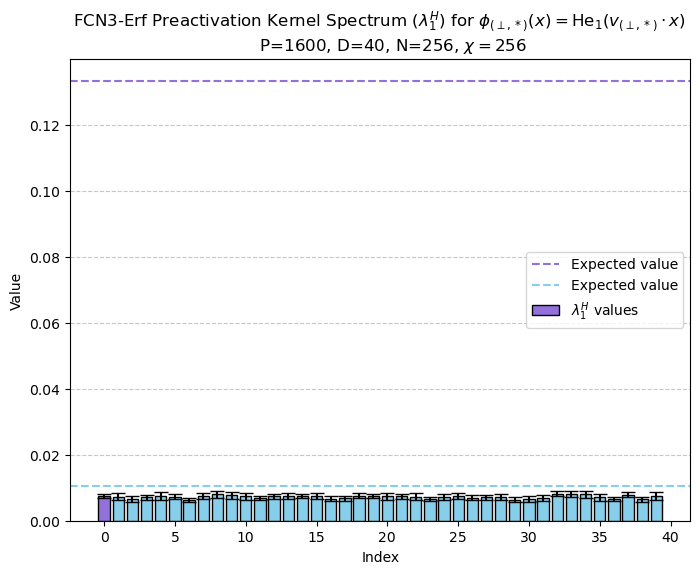

/home/akiva/exp/fcn3erf/erf_cubic_P_1600_D_40_N_256_epochs_40000000_lrA_6.25e-11_time_20251030_174053/


In [114]:
predictions = experimentMF.predictions
import numpy as np
import matplotlib.pyplot as plt
k = 'λH1'
print(
    f"lH1: {eigdict[k]} ± {eigdict[f'σ{k}']} ")

lH1_min = eigdict[k] - eigdict[f'σ{k}']
lH1_max = eigdict[k] + eigdict[f'σ{k}']
print(
    f"{k}_min: {lH1_min} ")
lH1expected = predictions.lH1P

print(f"{k}_expected: {lH1expected}")
print(
    f"{k}_max: {lH1_max} ")


# Calculate error bars: asymmetric from min to max relative to heights
yerr_min = eigdict['λH1'] - lH1_min  # Lower error
yerr_max = lH1_max - eigdict['λH1']  # Upper error
yerr = np.array([yerr_min, yerr_max])  # Shape (2, n) for asymmetric errors

# X positions for bars (assuming indexed by array position)
x = np.arange(len(eigdict['λH1']))
target1 = predictions.lH1T

# Create the bar plot
plt.figure(figsize=(8, 6))
colors = ['mediumpurple'] + ['skyblue'] * (len(eigdict['λH1']) - 1)

plt.bar(x, eigdict['λH1'], yerr=yerr, capsize=5,
        color=colors, edgecolor='black', label='$\lambda^H_1$ values')


plt.axhline(y=target1, color='mediumpurple',
            linestyle='--', label='Expected value')

# Add the red dashed line (horizontal across all bars if lH3expected is scalar; or point-wise if array)
if np.isscalar(lH1expected):
    plt.axhline(y=lH1expected, color='skyblue',
                linestyle='--', label='Expected value')
else:
    plt.plot(x, lH1expected, color='skyblue', linestyle='--',
             marker='o', label='Expected values')

# Labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("FCN3-Erf Preactivation Kernel Spectrum ($\lambda^H_1$) for $\phi_{(\perp, *)}(x) = $He$_1(v_{(\perp, *)} \cdot x)$ \n \
    P="+str(experimentMF.P)+", D="+str(experimentMF.d) +", N="+str(experimentMF.N)+", $\chi="+str(experimentMF.chi)+"$")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(os.path.join(experimentMF.file, 'lH1_eigenvalues_plot.png'),dpi=350)
# Show the plot
plt.show()
print(experimentMF.file)

λH3: [2.95160389e-05 4.52019362e-05 5.70082462e-05 6.20844216e-05
 7.61335653e-05 4.83814141e-05 4.59320860e-05 5.73717900e-05
 5.20824829e-05 5.69041887e-05 6.26205228e-05 4.45584172e-05
 5.51889188e-05 4.37439606e-05 6.93130357e-05 5.85872777e-05
 5.44173409e-05 4.70742311e-05 5.32331916e-05 5.04134698e-05
 5.60384505e-05 6.55134096e-05 4.68738483e-05 9.75915221e-05
 4.70613478e-05 5.67324398e-05 6.38380809e-05 7.20293838e-05
 6.87735819e-05 6.31149883e-05 4.04293229e-05 6.46789523e-05
 8.57724131e-05 7.14437767e-05 9.59923839e-05 5.21109475e-05
 1.67944276e-04 7.27003277e-05 7.05878468e-05 4.95213109e-05] ± [3.90281541e-06 5.27964582e-06 7.27140869e-06 4.85191463e-06
 9.91159280e-06 6.94721248e-06 4.40396783e-06 7.43494610e-06
 3.61597438e-06 6.55715922e-06 8.65123587e-06 6.43477451e-06
 4.87359509e-06 4.83611004e-06 5.69569235e-06 6.34982301e-06
 8.24864579e-06 4.57077050e-06 7.13353119e-06 4.36336953e-06
 6.00109950e-06 9.75852683e-06 5.10713947e-06 1.45336108e-05
 7.12708515e-06 

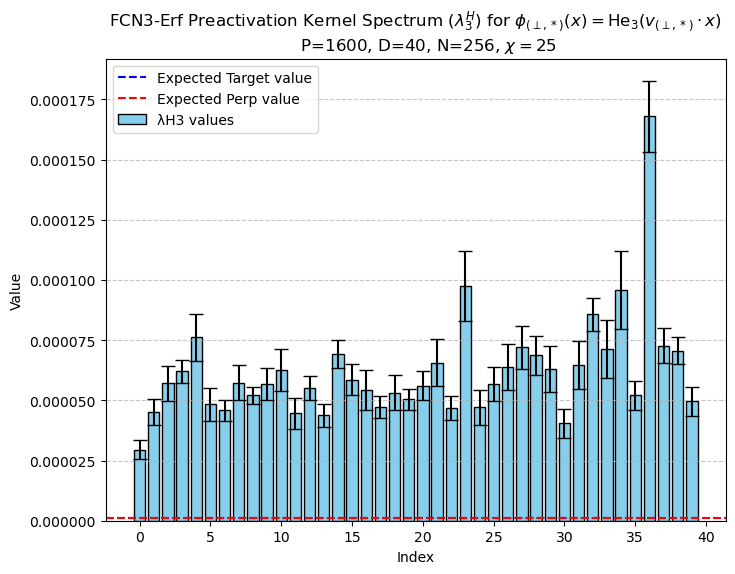

In [115]:
target3 = predictions.lH3T
lH3expected = predictions.lH3P
k = 'λH3'
print(
    f"{k}: {eigdict[k]} ± {eigdict[f'σ{k}']} ")

lH3_min = eigdict[k] - eigdict[f'σ{k}']
lH3_max = eigdict[k] + eigdict[f'σ{k}']
print(
    f"{k}_min: {lH3_min} ")


print(f"{k}_expected: {lH3expected}")
print(
    f"{k}_max: {lH3_max} ")


# Calculate error bars: asymmetric from min to max relative to heights
yerr_min = eigdict[k] - lH3_min  # Lower error
yerr_max = lH3_max - eigdict[k]  # Upper error
yerr = np.array([yerr_min, yerr_max])  # Shape (2, n) for asymmetric errors

# X positions for bars (assuming indexed by array position)
x = np.arange(len(eigdict[k]))

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(x, eigdict[k], yerr=yerr, capsize=5,
        color='skyblue', edgecolor='black', label='λH3 values')

plt.axhline(y=target3, color='blue',
            linestyle='--', label='Expected Target value')

# Add the red dashed line (horizontal across all bars if lH3expected is scalar; or point-wise if array)
if np.isscalar(lH3expected):
    plt.axhline(y=lH3expected, color='red',
                linestyle='--', label='Expected Perp value')
else:
    plt.plot(x, lH3expected, color='red', linestyle='--',
             marker='o', label='Expected Perp values')

# Labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('FCN3-Erf Preactivation Kernel Spectrum ($\lambda^H_3$) for $\phi_{(\perp, *)}(x) = $He$_3(v_{(\perp, *)} \cdot x)$ \n \
    P=1600, D=40, N=256, $\chi=25$ \
')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.ylim(0.0,0.001)
# Show the plot
plt.show()

I see in this plotobs

In [21]:
Y.shape

# Large matrix projection
P = 30

lH1 = model.H_eig(X_inf, Y1_inf)
lH3 = model.H_eig(X_inf, Y3_inf)
lK1 = model.K_eig(X_inf, Y1_inf)
lK3 = model.K_eig(X_inf, Y3_inf)

# Ensure we only index up to available eigenvalues
d_plot = min(int(lH1.shape[0]), int(lK1.shape[0]), 10)

scalarsH1 = {}
scalarsH3 = {}
scalarsK1 = {}
scalarsK3 = {}
muK1 = {}
muK3 = {}

# noise_term = kappa / P
noise_term = float(kappa) / float(P)

for i in range(d_plot):
    scalarsH1[str(i)] = lH1[i].item() if hasattr(
        lH1[i], 'item') else float(lH1[i])
    scalarsH3[str(i)] = lH3[i].item() if hasattr(
        lH3[i], 'item') else float(lH3[i])

    scalarsK1[str(i)] = lK1[i].item() if hasattr(
        lK1[i], 'item') else float(lK1[i])
    scalarsK3[str(i)] = lK3[i].item() if hasattr(
        lK3[i], 'item') else float(lK3[i])

    # learnability mu = lKi / (lKi + kappa/P)
    li_k1 = lK1[i].item() if hasattr(
        lK1[i], 'item') else float(lK1[i])
    li_k3 = lK3[i].item() if hasattr(
        lK3[i], 'item') else float(lK3[i])
    muK1[str(i)] = li_k1 / (li_k1 + noise_term + 1e-30)
    muK3[str(i)] = li_k3 / (li_k3 + noise_term + 1e-30)

# Log to TensorBoard

# Randomized SVD Approach   

In [ ]:
del experimentMF


In [1]:
import sys
import scipy.stats as stats
sys.path.insert(0, '/home/akiva/FCNX-Ensembling/lib')
import torch
from Experiment import Experiment 
# experimentMF = Experiment(
#     eps=0.03,
#     file = '/home/akiva/exp/fcn3erf/erf_cubic_P_1600_D_40_N_256_epochs_40000000_lrA_6.25e-11_time_20251030_174053',
#     N=256,
#     d=40,
#     chi=25,
#     P=1600,
#     ens=10,
#     device = torch.device('cuda:1')
# )

# experimentMF = Experiment(
#     eps = 0.03, 
#     file = '/home/akiva/exp/fcn3erf/erf_cubic_P_30_D_25_N_250_epochs_40000000_lrA_1.11e-08_time_20251030_121338',
#     N=250,
#     d=25,
#     ens=5,
#     chi=1.0,
#     P=30
# )

# experimentMF = Experiment(
#     eps=0.00,
#     file = '/home/akiva/exp/fcn3erf/erf_P_30_D_25_N_250_epochs_250000000_lrA_1.11e-07_time_20250922_144935',
#     N=250,
#     d=25,
#     chi=250,
#     P=30,
#     ens=7,
# )

# experimentMF = Experiment(
#     file = '/home/akiva/exp/fcn3erf/erf_cubic_P_130_D_25_N_250_epochs_300000000_lrA_7.69e-09_time_20251030_175255',
#     P = 130,
#     d=25,
#     N=250,
#     chi=25,
#     ens=25,
#     eps=0.00
# )

# experimentMF = Experiment(
#     file = '/home/akiva/exp/fcn3erf/erf_cubic_P_1875_D_25_N_400_epochs_2000000_lrA_1.78e-09_time_20251112_161015',
#     P = 1875,
#     d=25,
#     N=400,
#     chi=100,
#     eps=0.4,
#     ens=5)

# experimentMF = Experiment(
#     d=25,
#     P=30,
#     N=250,
#     ens = 7, 
#     eps = 0.4,
#     chi=250,
#     file = '/home/akiva/exp/fcn3erf/erf_cubic_P_30_D_25_N_250_epochs_25000000_lrA_1.11e-07_time_20251113_122128',
# )

# experimentMF = Experiment(
#     file='/home/akiva/exp/fcn3erf/erf_cubic_P_2500_D_50_N_400_epochs_30000000_lrA_1.33e-07_time_20251113_151231/',
#     device=torch.device('cuda:1'),
#     P=2500,
#     d=50,
#     N=400,
#     chi=100,
#     eps=4.0,
#     ens=8)

# experimentMF = Experiment(
#     file = '/home/akiva/exp/fcn3erf/erf_cubic_P_300_D_20_N_200_epochs_30000000_lrA_1.11e-06_time_20251116_110854/',
#     device=torch.device('cuda:1'),
#     P = 300,
#     d=20,
#     N=200,
#     chi=200,
#     eps=4.0,
#     ens = 5)

# experimentMF = Experiment(
#     file='/home/akiva/exp/fcn3erf/erf_cubic_P_250_D_20_N_120_epochs_30000000_lrA_1.33e-07_time_20251116_210435',
#     device=torch.device('cuda:1'),
#     P=250,
#     d=20,
#     N=120,
#     chi=60,
#     eps=0.4,
#     ens=10)

experimentMF = Experiment(
    file='/home/akiva/exp/d_sweep_correct_50to150d/erf_cubic_eps_0.03_P_370_D_74_N_296_epochs_20000000_lr_1.50e-05/',
    P = 370,
    d=74,
    N=296,
    chi=296,
    eps=0.03,
    ens=3,
    device=torch.device('cuda:1')
)

import torch
# experimentMFSmallD.load()
experimentMF.load(compute_predictions=True)
model = experimentMF.model
experimentMF.model.device = experimentMF.device
experimentMF.model.to(experimentMF.device)

experimentMF.predictions = experimentMF.eig_predictions()
# torch.set_printoptions(precision=8)

# print("Leading order eigenvalues:")
# print(ls[(ls > 1e-2) & (ls < 5e-1)])
# print("Second order eigenvalues")

# print(ls[(ls > 1e-5) & (ls < 1e-3)])


/home/akiva/miniconda3/envs/ml_env/lib/python3.12/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


/home/akiva/FCNX-Ensembling/lib/Experiment.py:343: SyntaxWarning: invalid escape sequence '\m'
  color=colors[0], linestyle='--', label='$\mathbb{E}\;[\lambda^{H1}_T]$')
/home/akiva/FCNX-Ensembling/lib/Experiment.py:345: SyntaxWarning: invalid escape sequence '\m'
  color=colors[1], linestyle='-',  label='$\mathbb{E}\;[\lambda^{H1}_P]$')
/home/akiva/FCNX-Ensembling/lib/Experiment.py:347: SyntaxWarning: invalid escape sequence '\m'
  color=colors[2], linestyle='--', label='$\mathbb{E}\;[\lambda^{H3}_T]$')
/home/akiva/FCNX-Ensembling/lib/Experiment.py:349: SyntaxWarning: invalid escape sequence '\m'
  color=colors[3], linestyle='-',  label='$\mathbb{E}\;[\lambda^{H3}_P]$')
/home/akiva/FCNX-Ensembling/lib/Experiment.py:356: SyntaxWarning: invalid escape sequence '\l'
  color=colors[0], label='$\lambda^{H1}_T$')
/home/akiva/FCNX-Ensembling/lib/Experiment.py:360: SyntaxWarning: invalid escape sequence '\l'
  color=colors[1], label='$\lambda^{H1}_P$')
/home/akiva/FCNX-Ensembling/lib/Experime

FileNotFoundError: [Errno 2] No such file or directory: '/home/akiva/exp/d_sweep_correct_50to150d/erf_cubic_eps_0.03_P_370_D_74_N_296_epochs_20000000_lr_1.50e-05/model.pth'

In [ ]:
X, Yi = experimentMF.large_dataset(p_large=10000, device=experimentMF.device)
Y1, Y3 = Yi

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import scipy.stats as stats
sys.path.insert(0, '/home/akiva/FCNX-Ensembling/lib')
import torch
from Experiment import Experiment 

experiments = [
    Experiment(
        eps=0.03,
        file = '/home/akiva/exp/fcn3erf/erf_cubic_P_1600_D_40_N_256_epochs_40000000_lrA_6.25e-11_time_20251030_174053',
        N=256,
        d=40,
        chi=25,
        P=1600,
        ens=10,
        device = torch.device('cuda:1')
    ),Experiment(
        eps = 0.03, 
        file = '/home/akiva/exp/fcn3erf/erf_cubic_P_30_D_25_N_250_epochs_40000000_lrA_1.11e-08_time_20251030_121338',
        N=250,
        d=25,
        ens=5,
        chi=1.0,
        P=30
    ),Experiment(
        eps=0.00,
        file = '/home/akiva/exp/fcn3erf/erf_P_30_D_25_N_250_epochs_250000000_lrA_1.11e-07_time_20250922_144935',
        N=250,
        d=25,
        chi=250,
        P=30,
        ens=7,
    ), Experiment(
        file = '/home/akiva/exp/fcn3erf/erf_cubic_P_130_D_25_N_250_epochs_300000000_lrA_7.69e-09_time_20251030_175255',
        P = 130,
        d=25,
        N=250,
        chi=25,
        ens=25,
        eps=0.00
    ), Experiment(
        file = '/home/akiva/exp/fcn3erf/erf_cubic_P_1875_D_25_N_400_epochs_2000000_lrA_1.78e-09_time_20251112_161015',
        P = 1875,
        d=25,
        N=400,
        chi=100,
        eps=0.4,
        ens=5
    ), Experiment(
        d=25,
        P=30,
        N=250,
        ens = 7, 
        eps = 0.4,
        chi=250,
        file = '/home/akiva/exp/fcn3erf/erf_cubic_P_30_D_25_N_250_epochs_25000000_lrA_1.11e-07_time_20251113_122128'
    ), Experiment(
        file='/home/akiva/exp/fcn3erf/erf_cubic_P_2500_D_50_N_400_epochs_30000000_lrA_1.33e-07_time_20251113_151231/',
        device=torch.device('cuda:1'),
        P=2500,
        d=50,
        N=400,
        chi=100,
        eps=4.0,
        ens=8
    ), Experiment(
        file = '/home/akiva/exp/fcn3erf/erf_cubic_P_300_D_20_N_200_epochs_30000000_lrA_1.11e-06_time_20251116_110854/',
        device=torch.device('cuda:1'),
        P = 300,
        d=20,
        N=200,
        chi=200,
        eps=4.0,
        ens = 5
    ), Experiment(
        file='/home/akiva/exp/fcn3erf/erf_cubic_P_250_D_20_N_120_epochs_30000000_lrA_1.33e-07_time_20251116_210435',
        device=torch.device('cuda:1'),
        P=250,
        d=20,
        N=120,
        chi=60,
        eps=0.4,
        ens=10
    ), Experiment(
    file='/home/akiva/exp/fcn3erf/erf_cubic_eps_0.3_P_2500_D_40_N_400_epochs_25000000_lrA_1.33e-07_time_20251117_132840/',
    P = 1000,
    d=40,
    N=400,
    chi=100,
    eps=0.3,
    ens=3,
    device=torch.device('cuda:1'))
]

/home/akiva/miniconda3/envs/ml_env/lib/python3.11/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


<>:55: SyntaxWarning: invalid escape sequence '\P'
<>:56: SyntaxWarning: invalid escape sequence '\P'
<>:59: SyntaxWarning: invalid escape sequence '\l'
<>:63: SyntaxWarning: invalid escape sequence '\P'
<>:64: SyntaxWarning: invalid escape sequence '\P'
<>:67: SyntaxWarning: invalid escape sequence '\l'
<>:71: SyntaxWarning: invalid escape sequence '\P'
<>:72: SyntaxWarning: invalid escape sequence '\P'
<>:75: SyntaxWarning: invalid escape sequence '\l'
<>:80: SyntaxWarning: invalid escape sequence '\P'
<>:81: SyntaxWarning: invalid escape sequence '\P'
<>:84: SyntaxWarning: invalid escape sequence '\l'
<>:107: SyntaxWarning: invalid escape sequence '\l'
<>:55: SyntaxWarning: invalid escape sequence '\P'
<>:56: SyntaxWarning: invalid escape sequence '\P'
<>:59: SyntaxWarning: invalid escape sequence '\l'
<>:63: SyntaxWarning: invalid escape sequence '\P'
<>:64: SyntaxWarning: invalid escape sequence '\P'
<>:67: SyntaxWarning: invalid escape sequence '\l'
<>:71: SyntaxWarning: invalid 

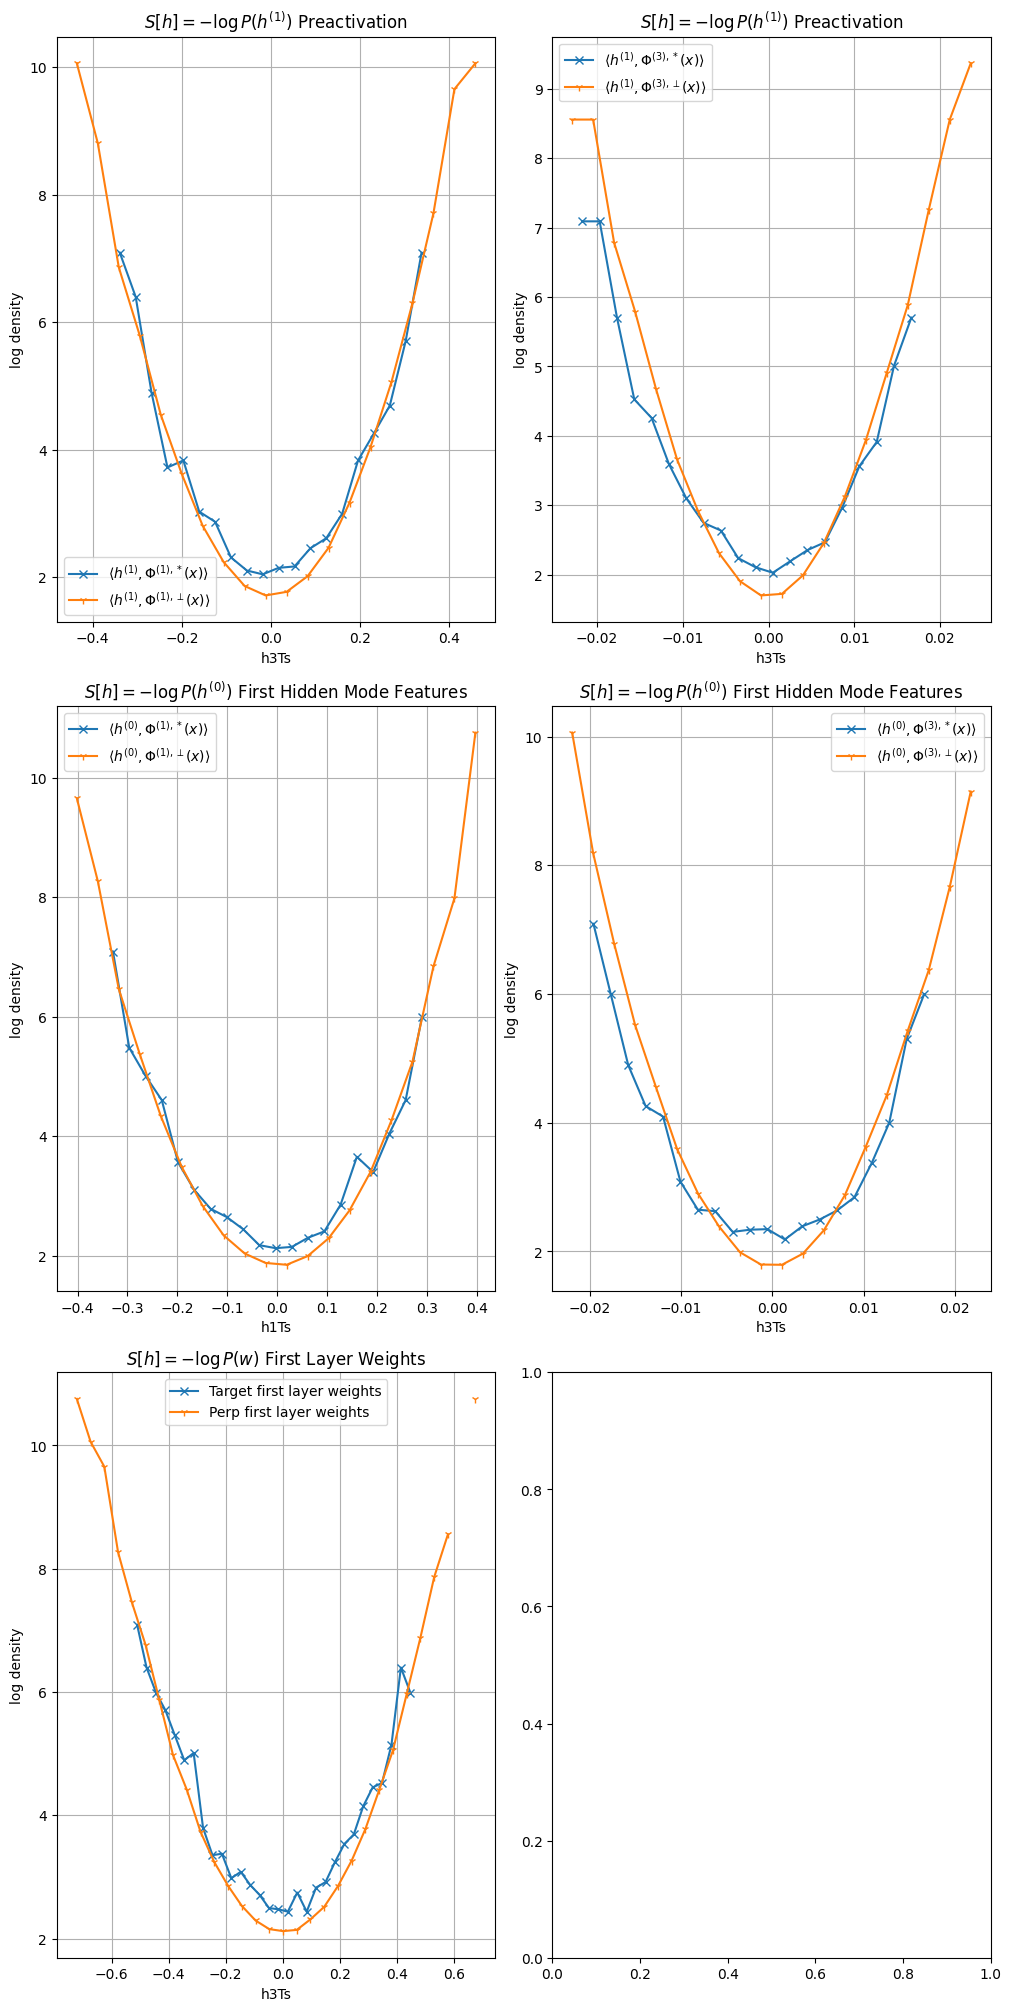

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import scipy.stats as stats
sys.path.insert(0, '/home/akiva/FCNX-Ensembling/lib')
import torch
from Experiment import Experiment 

experimentMF = Experiment(
        eps=0.03,
        file = '/home/akiva/exp/fcn3erf/erf_cubic_eps_0.03_P_250_D_40_N_400_epochs_25000000_lrA_1.33e-06_time_20251118_155401',
        N=400,
        d=40,
        chi=50,
        P=250,
        ens=3,
        device = torch.device('cuda:1')
    )
X, Yi = experimentMF.large_dataset(p_large=3000)
Y1, Y3 = Yi
model = experimentMF.model
model.to(experimentMF.device)
def log_density_of_projections(h,y):

    hs = torch.einsum('uji,uk->jik', h, y) / (y.shape[0])
    heTs = hs.flatten(start_dim=0, end_dim=1)[:,0].detach().cpu().numpy()
    hePs = hs.flatten(start_dim=0, end_dim=1)[:,1:].detach().cpu().numpy().flatten()

    countsT, bin_edgesT = np.histogram(heTs, bins=20,density= True)
    countsP, bin_edgesP = np.histogram(hePs, bins=20,density= True)

    # Bin width
    bw = lambda be: be[1] - be[0]
    bc = lambda be: 0.5 * (be[:-1] + be[1:])
    # Compute log density
    log_density_T = -np.log(countsT * bw(bin_edgesT))  # add epsilon to avoid log(0)
    log_density_P = -np.log(countsP * bw(bin_edgesP))  # add epsilon to avoid log(0)
    return bc(bin_edgesT), log_density_T, bc(bin_edgesP), log_density_P

h1 = model.h1_preactivation(X)
h0 = torch.erf(torch.einsum(
            'qkl,ul->uqk',
            model.W0, X
        ))
bc1T, ld1T, bc1P, ld1P = log_density_of_projections(h1, Y1)
bc3T, ld3T, bc3P, ld3P = log_density_of_projections(h1, Y3)
h0bc1T, h0ld1T, h0bc1P, h0ld1P = log_density_of_projections(h0, Y1)
h0bc3T, h0ld3T, h0bc3P, h0ld3P = log_density_of_projections(h0, Y3)

# Plot
fig, ax = plt.subplots(3, 2, figsize=(10,20), layout='constrained')
# Option 2: Modifying rcParams

ax[0,0].plot(bc1T, ld1T, marker='x', label='$\\langle h^{(1)} , \Phi^{(1),*}(x) \\rangle$')
ax[0,0].plot(bc1P, ld1P, marker='1', label='$\\langle h^{(1)} , \Phi^{(1),\perp}(x) \\rangle$')
ax[0,0].set_xlabel("h3Ts")
ax[0,0].set_ylabel("log density")
ax[0,0].set_title("$S[h] = -\log P(h^{(1)})$ Preactivation")
ax[0,0].grid(True)
ax[0,0].legend()

ax[0,1].plot(bc3T, ld3T, marker='x', label='$\\langle h^{(1)} , \Phi^{(3),*}(x) \\rangle$')
ax[0,1].plot(bc3P, ld3P, marker='1', label='$\\langle h^{(1)} , \Phi^{(3),\perp}(x) \\rangle$')
ax[0,1].set_xlabel("h3Ts")
ax[0,1].set_ylabel("log density")
ax[0,1].set_title("$S[h] = -\log P(h^{(1)})$ Preactivation")
ax[0,1].grid(True)
ax[0,1].legend()

ax[1,0].plot(h0bc1T, h0ld1T, marker='x', label='$\\langle h^{(0)} , \Phi^{(1),*}(x) \\rangle$')
ax[1,0].plot(h0bc1P, h0ld1P, marker='1', label='$\\langle h^{(0)} , \Phi^{(1),\perp}(x) \\rangle$')
ax[1,0].set_xlabel("h1Ts")
ax[1,0].set_ylabel("log density")
ax[1,0].set_title("$S[h] = -\log P(h^{(0)})$ First Hidden Mode Features")
ax[1,0].grid(True)
ax[1,0].legend()
# ax[1,0].set_xlim((-.6,.6))

ax[1,1].plot(h0bc3T, h0ld3T, marker='x', label='$\\langle h^{(0)} , \Phi^{(3),*}(x) \\rangle$')
ax[1,1].plot(h0bc3P, h0ld3P, marker='1', label='$\\langle h^{(0)} , \Phi^{(3),\perp}(x) \\rangle$')
ax[1,1].set_xlabel("h3Ts")
ax[1,1].set_ylabel("log density")
ax[1,1].set_title("$S[h] = -\log P(h^{(0)})$ First Hidden Mode Features")
ax[1,1].grid(True)
ax[1,1].legend()
# ax[1,1].set_xlim((-.25,.25))

w0T = model.W0[:,:,0].detach().cpu().numpy()
w0P = model.W0[:,:,1:].detach().cpu().numpy()
ctT, bneT = np.histogram(w0T, bins=30,density= True)
ctP, bneP = np.histogram(w0P, bins=30,density= True)

# Bin width
bw = lambda be: be[1] - be[0]
bc = lambda be: 0.5 * (be[:-1] + be[1:])
# Compute log density
w0ldT = -np.log(ctT * bw(bneT))  # add epsilon to avoid log(0)
w0ldP = -np.log(ctP * bw(bneP))  # add epsilon to avoid log(0)
w0bcT = bc(bneT)
w0bcP = bc(bneP)

ax[2,0].plot(w0bcT, w0ldT, marker='x', label='Target first layer weights')
ax[2,0].plot(w0bcP, w0ldP, marker='1', label='Perp first layer weights')
ax[2,0].set_xlabel("h3Ts")
ax[2,0].set_ylabel("log density")
ax[2,0].set_title("$S[h] = -\log P(w)$ First Layer Weights")
ax[2,0].grid(True)
ax[2,0].legend()
# ax[2,0].set_xlim((-.5,.5))

# ax[2,1].plot(h0bc3T, h0ld3T, marker='x', label='$\\langle h^{(0)} , \Phi^{(3),*}(x) \\rangle$')
# ax[2,1].plot(h0bc3P, h0ld3P, marker='o', label='$\\langle h^{(0)} , \Phi^{(3),\perp}(x) \\rangle$')
# ax[2,1].set_xlabel("h3Ts")
# ax[2,1].set_ylabel("log density")
# ax[2,1].set_title("$S[h] = -\log P(h^{(0)})$ First Hidden Mode Features")
# ax[2,1].grid(True)
# ax[2,1].legend()

plt.show()

/tmp/ipykernel_1091460/1870477502.py:45: RuntimeWarning: divide by zero encountered in log
  ldT = -np.log(ctT * bw(bneT))
/tmp/ipykernel_1091460/1870477502.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs.legend()


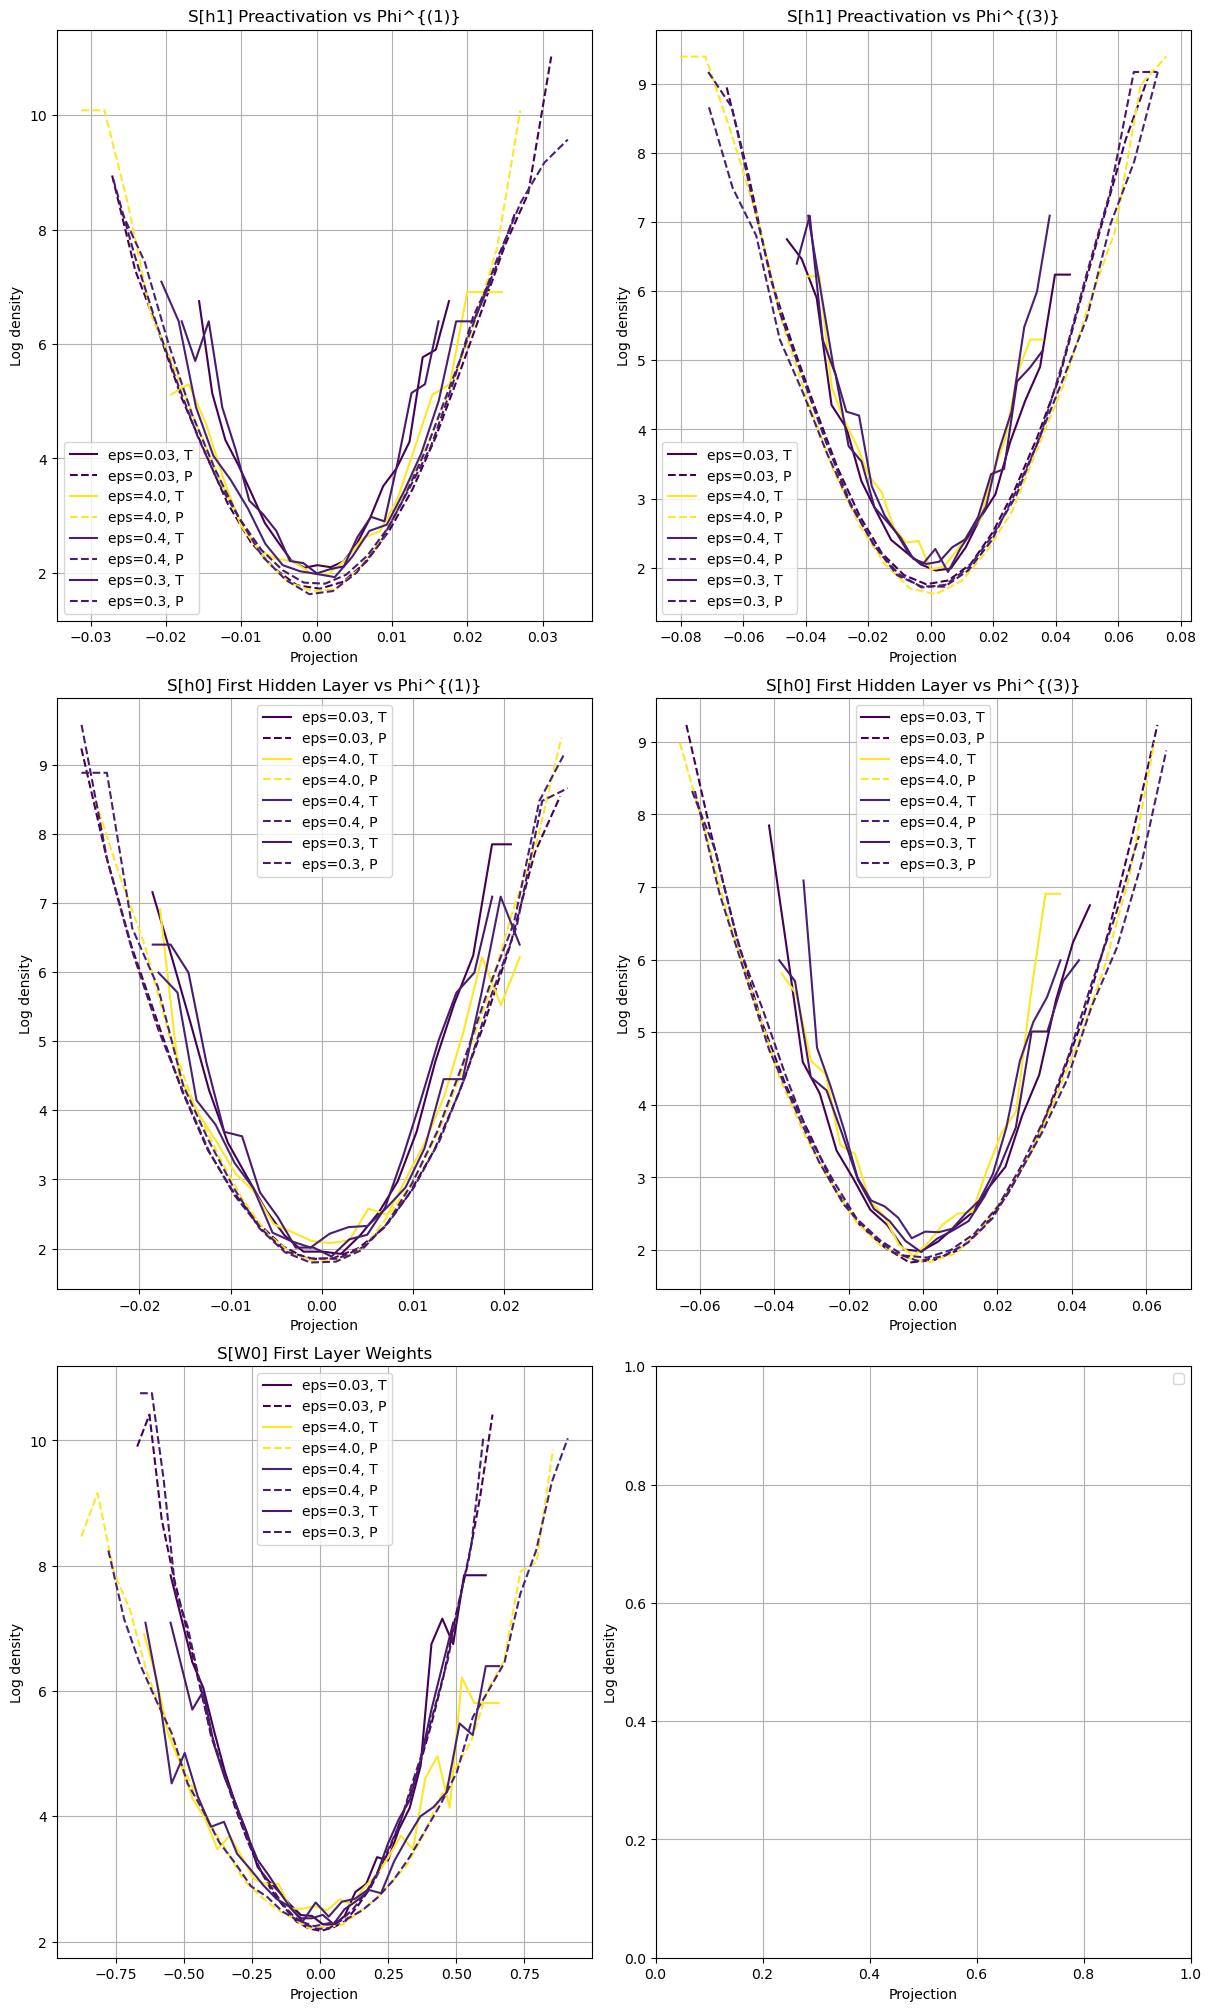

In [82]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Define line styles
line_styles = {'T': '-', 'P': '--'}

# Normalize epsilon values for colormap
eps_values = [exp.eps if hasattr(exp, 'eps') else 0.0 for exp in experiments]
norm = plt.Normalize(min(eps_values), max(eps_values))
cmap = cm.viridis

# Precompute X and model from first experiment (assuming all experiments use same input space)

fig, ax = plt.subplots(3, 2, figsize=(12, 20), layout='constrained')

for experiment in experiments:
    model = experiment.model
    model.to(torch.device('cuda:1'))
    # Compute preactivations
    X, _ = experiment.large_dataset(p_large=10000, device=torch.device('cuda:1'))

    h1 = model.h1_preactivation(X)
    h0 = torch.erf(torch.einsum('qkl,ul->uqk', model.W0, X))
    
    # Compute log densities for Y1 and Y3
    for Y, row_label in zip([Y1, Y3], ['1','2']):
        bcT, ldT, bcP, ldP = log_density_of_projections(h1, Y)
        ax_idx = (0, int(row_label)-1)
        ax[0, int(row_label)-1].plot(bcT, ldT, color=cmap(norm(experiment.eps)), linestyle=line_styles['T'], label=f'eps={experiment.eps}, T')
        ax[0, int(row_label)-1].plot(bcP, ldP, color=cmap(norm(experiment.eps)), linestyle=line_styles['P'], label=f'eps={experiment.eps}, P')
        
        # First hidden layer
        bcT0, ldT0, bcP0, ldP0 = log_density_of_projections(h0, Y)
        ax[1, int(row_label)-1].plot(bcT0, ldT0, color=cmap(norm(experiment.eps)), linestyle=line_styles['T'], label=f'eps={experiment.eps}, T')
        ax[1, int(row_label)-1].plot(bcP0, ldP0, color=cmap(norm(experiment.eps)), linestyle=line_styles['P'], label=f'eps={experiment.eps}, P')

    # First layer weights
    w0T = model.W0[:,:,0].detach().cpu().numpy()
    w0P = model.W0[:,:,1:].detach().cpu().numpy()
    ctT, bneT = np.histogram(w0T, bins=30,density=True)
    ctP, bneP = np.histogram(w0P, bins=30,density=True)
    bw = lambda be: be[1]-be[0]
    bc = lambda be: 0.5*(be[:-1]+be[1:])
    ldT = -np.log(ctT * bw(bneT))
    ldP = -np.log(ctP * bw(bneP))
    ax[2,0].plot(bc(bneT), ldT, color=cmap(norm(experiment.eps)), linestyle=line_styles['T'], label=f'eps={experiment.eps}, T')
    ax[2,0].plot(bc(bneP), ldP, color=cmap(norm(experiment.eps)), linestyle=line_styles['P'], label=f'eps={experiment.eps}, P')

# Titles and labels
ax[0,0].set_title("S[h1] Preactivation vs Phi^{(1)}")
ax[0,1].set_title("S[h1] Preactivation vs Phi^{(3)}")
ax[1,0].set_title("S[h0] First Hidden Layer vs Phi^{(1)}")
ax[1,1].set_title("S[h0] First Hidden Layer vs Phi^{(3)}")
ax[2,0].set_title("S[W0] First Layer Weights")
for axs in ax.flatten():
    axs.set_xlabel("Projection")
    axs.set_ylabel("Log density")
    axs.grid(True)
    # Optional: Only show legend in first row to avoid clutter
    axs.legend()

plt.show()


[Random Omega generation] 0.0000s
[  res chunk [0:1000]] 0.0024s
[res computation (chunks of 4096)] 0.0040s
[QR factorisation] 0.0023s
[  Z chunk [0:1000]] 0.0000s
[Z computation (chunks of 4096)] 0.0023s
[B = Q.T @ Z] 0.0000s
[eigvalsh] 0.1372s
[final sort] 0.0000s


In [68]:
experimentMF.predictions

Eigenvalues(lJ1T=0.010545270230877759, lJ3T=4.3401441413413423e-05, lH1T=0.04421250783439252, lH3T=4.365973605191249e-05, lJ1P=0.010610329539460598, lJ3P=4.42097064144154e-05, lH1P=0.010610329539460598, lH3P=4.42097064144154e-05)

In [1]:
experimentMF = Experiment(
        eps=0.03,
        file = '/home/akiva/exp/fcn3erf/erf_cubic_P_1600_D_40_N_256_epochs_40000000_lrA_6.25e-11_time_20251030_174053',
        N=256,
        d=40,
        chi=25,
        P=1600,
        ens=10,
        device = torch.device('cuda:1')
    )


experimentGP = Experiment(
    file='',
    P=experimentMF.P,
    d=experimentMF.d,
    N=experimentMF.N,
    chi=experimentMF.chi,
    eps=experimentMF.eps,
    ens=experimentMF.ens,
    device=torch.device('cuda:1')
)

experimentMF = Experiment(
        eps=0.03,
        file = '/home/akiva/exp/fcn3erf/erf_cubic_eps_0.03_P_250_D_40_N_400_epochs_25000000_lrA_1.33e-06_time_20251118_155401',
        N=400,
        d=40,
        chi=50,
        P=250,
        ens=3,
        device = torch.device('cuda:1')
    )

X, Yi = experimentMF.large_dataset(p_large=3000, device=experimentMF.device)

experimentGP.model.device = experimentGP.device
experimentGP.model.to(experimentGP.device)
ls_GP = experimentGP.model.H_eig_random_svd(X, k=500)


model = experimentMF.model
experimentMF.predictions = experimentMF.eig_predictions()
experimentMF.model.device = experimentMF.device
experimentMF.model.to(experimentMF.device)


NameError: name 'Experiment' is not defined

In [ ]:


experimentMF = Experiment(
        eps=0.03,
        file = '/home/akiva/exp/fcn3erf/erf_cubic_eps_0.03_P_250_D_40_N_400_epochs_25000000_lrA_1.33e-06_time_20251118_155401',
        N=400,
        d=40,
        chi=50,
        P=250,
        ens=3,
        device = torch.device('cuda:1')
    )
    
experimentGP.predictions = experimentMF.eig_predictions()

import matplotlib.pyplot as plt
ls_np = ls[40:].detach().cpu().numpy()
ls_GP_np = ls_GP[40:].detach().cpu().numpy()
plt.axhline(y=experimentGP.predictions.lH3T, color='blue',
            linestyle='--', label='MF Target lH3 Expected')
plt.axhline(y=experimentGP.predictions.lH3P, color='orange', linestyle='--', label='MF Perp lH3 Expected')
plt.plot(ls_np, marker='o', label='MF Model')
plt.plot(ls_GP_np, marker='x', label='GP Initialization Model')
# plt.yscale('log')
plt.legend()
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue (log scale)')
plt.title('Eigenvalues of H via Randomized SVD')
# plt.xscale('log')
plt.grid(True, which="both", ls="--")
plt.show()

NameError: name 'Experiment' is not defined

In [7]:
import numpy as np


def same_order_mask(a, b, eps=1):
    """
    Returns True where |floor(log10|a|) - floor(log10|b|)| <= eps
    eps=0  → exact same order (your original)
    eps=1  → allows one order of magnitude difference (most common soft version)
    """
    a, b = np.asarray(a), np.asarray(b)
    zero = (a == 0) & (b == 0)
    both_nonzero = (a != 0) & (b != 0)
    exp_a = np.log10(np.abs(a))
    exp_b = np.log10(np.abs(b))
    close = np.abs(exp_a - exp_b) <= eps
    return zero | (both_nonzero & close)

In [ ]:
import numpy as np


def same_order_mask(a, b, eps=1):
    """
    Returns True where |floor(log10|a|) - floor(log10|b|)| <= eps
    eps=0  → exact same order (your original)
    eps=1  → allows one order of magnitude difference (most common soft version)
    """
    a, b = np.asarray(a), np.asarray(b)
    zero = (a == 0) & (b == 0)
    both_nonzero = (a != 0) & (b != 0)
    exp_a = np.log10(np.abs(a))
    exp_b = np.log10(np.abs(b))
    close = np.abs(exp_a - exp_b) <= eps
    return zero | (both_nonzero & close)

tensor(0.0658, device='cuda:1')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import sys
import scipy.stats as stats
sys.path.insert(0, '/home/akiva/FCNX-Ensembling/lib')
from Experiment import Experiment 
%load_ext autoreload
%autoreload 2

import numpy as np


def same_order_mask(a, b, eps=1):
    """
    Returns True where |floor(log10|a|) - floor(log10|b|)| <= eps
    eps=0  → exact same order (your original)
    eps=1  → allows one order of magnitude difference (most common soft version)
    """
    a, b = np.asarray(a), np.asarray(b)
    zero = (a == 0) & (b == 0)
    both_nonzero = (a != 0) & (b != 0)
    exp_a = np.log10(np.abs(a))
    exp_b = np.log10(np.abs(b))
    close = np.abs(exp_a - exp_b) <= eps
    return zero | (both_nonzero & close)
    
experimentMF = Experiment(
    file='/home/akiva/exp/d_sweep_correct_50to150d/erf_cubic_eps_0.03_P_370_D_74_N_296_epochs_20000000_lr_1.50e-05/',
    P = 370,
    d=74,
    N=296,
    chi=296,
    eps=0.03,
    ens=3,
    device=torch.device('cuda:1')
)


experimentMF.load()
experimentMF.model.to(experimentMF.device)
experimentMF.predictions = experimentMF.eig_predictions()
X, Y1,Y3 = experimentMF.large_dataset(p_large = 10_000, flat=True)
experimentMF.model.device = experimentMF.device
print("Model device is: ", experimentMF.model.device)
# Available CPU memory:
import psutil
mem = psutil.virtual_memory()
print(f"Available memory: {mem.available / (1024**3):.2f} GB")
# Available memory not in use:
print(f"Free memory: {mem.free / (1024**3):.2f} GB")
# compute the svd of the low rank approximaton to H
# Random svd goes from H ∈ ℝ^m*m to its low rank approximation QB ∈ ℝ^m*m with Q ∈ ℝ^m*l and B ∈ ℝ^l*k. 
Q, Z = experimentMF.model.H_random_QB(X, k = 2000, p=10)
Ut, _S, V = torch.linalg.svd(Z.T)
m, n = Z.shape[1], Z.shape[0]
k = min(m, n)
Sigma = torch.zeros(m, n, device=Z.device, dtype=Z.dtype)
Sigma[:k, :k] = torch.diag(_S) 
U = torch.matmul(Q, Ut)
ls = Sigma.diagonal() / X.shape[0]
Y1_norm = Y1 / torch.norm(Y1, dim=0) 
left_eigenvaluesY1 = experimentMF.model.H_eig(X, Y1_norm) #(torch.matmul(Y1_norm.t(), U) @ _S.diag() @ torch.matmul(U.T, Y1_norm)).diagonal() / torch.norm(Y1_norm, dim=0)/ X.shape[0]
Y3_norm = Y3 / torch.norm(Y3, dim=0) 
left_eigenvaluesY3 = (torch.matmul(Y3_norm.t(), U) @ _S.diag() @ torch.matmul(U.T, Y3_norm)).diagonal() / torch.norm(Y3_norm, dim=0)/ X.shape[0]
left_eigenvalues = torch.cat([left_eigenvaluesY1, left_eigenvaluesY3], dim=0)

/home/akiva/miniconda3/envs/ml_env/lib/python3.12/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


/home/akiva/FCNX-Ensembling/lib/Experiment.py:343: SyntaxWarning: invalid escape sequence '\m'
  color=colors[0], linestyle='--', label='$\mathbb{E}\;[\lambda^{H1}_T]$')
/home/akiva/FCNX-Ensembling/lib/Experiment.py:345: SyntaxWarning: invalid escape sequence '\m'
  color=colors[1], linestyle='-',  label='$\mathbb{E}\;[\lambda^{H1}_P]$')
/home/akiva/FCNX-Ensembling/lib/Experiment.py:347: SyntaxWarning: invalid escape sequence '\m'
  color=colors[2], linestyle='--', label='$\mathbb{E}\;[\lambda^{H3}_T]$')
/home/akiva/FCNX-Ensembling/lib/Experiment.py:349: SyntaxWarning: invalid escape sequence '\m'
  color=colors[3], linestyle='-',  label='$\mathbb{E}\;[\lambda^{H3}_P]$')
/home/akiva/FCNX-Ensembling/lib/Experiment.py:356: SyntaxWarning: invalid escape sequence '\l'
  color=colors[0], label='$\lambda^{H1}_T$')
/home/akiva/FCNX-Ensembling/lib/Experiment.py:360: SyntaxWarning: invalid escape sequence '\l'
  color=colors[1], label='$\lambda^{H1}_P$')
/home/akiva/FCNX-Ensembling/lib/Experime

FileNotFoundError: [Errno 2] No such file or directory: '/home/akiva/exp/d_sweep_correct_50to150d/erf_cubic_eps_0.03_P_370_D_74_N_296_epochs_20000000_lr_1.50e-05/model.pth'

In [22]:
ls3_np.shape

(2010,)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
MF_eigenvalues = experimentMF.predictions
# ------------------------------------------------------------------
# 1. Choose colormap
# ------------------------------------------------------------------
cmap_name = "viridis"          # or "magma"
cmap = plt.get_cmap(cmap_name)
colors = cmap(np.linspace(0, 1, 4))

# ------------------------------------------------------------------
# 2. Move ls3 to CPU and convert to NumPy early
# ------------------------------------------------------------------
ls3 = left_eigenvalues  # assuming ls is your eigenvalue tensor
ls3_np = ls3.detach().cpu().numpy()
eig_upto = ls3.shape[0]  # or set to desired number of eigenvalues



# ------------------------------------------------------------------
# 3. Create boolean masks → **convert to NumPy immediately**
# ------------------------------------------------------------------
idx_big_np = (ls3_np == ls3_np.max()
              ) & (np.arange(len(ls3_np)) < eig_upto)
idx_mid1_np = same_order_mask(experimentMF.predictions.lH1P, ls3_np) & (ls3_np < ls3_np.max())  & (np.arange(len(ls3_np)) < eig_upto)
idx_mid_np = ~idx_mid1_np & same_order_mask(experimentMF.predictions.lH3T, ls3_np, eps=1) & (np.arange(len(ls3_np)) < eig_upto)
idx_small_np = same_order_mask(experimentMF.predictions.lH3P, ls3_np, eps=0.01) & (
    np.arange(len(ls3_np)) < eig_upto)

# Count sizes
n_big   = np.sum(idx_big_np)
n_mid1 = np.sum(idx_mid1_np)
n_mid   = np.sum(idx_mid_np)
n_small = np.sum(idx_small_np)

# ------------------------------------------------------------------
# 4. Build bar positions (NumPy)
# ------------------------------------------------------------------
pos_big   = np.arange(0, n_big)
pos_mid1 = np.arange(n_big, n_big + n_mid1)
pos_mid   = np.arange(n_big + n_mid1, n_big + n_mid + n_mid1)
pos_small = np.arange(n_big + n_mid + n_mid1, n_big + n_mid + n_mid1 + n_small)

# ------------------------------------------------------------------
# 5. Horizontal target lines
# ------------------------------------------------------------------
plt.axhline(y=MF_eigenvalues.lH1T, color=colors[0], linestyle='--', label='$\mathbb{E}\;[\lambda^{H1}_T]=$' + f'{MF_eigenvalues.lH1T:.5f}')
plt.axhline(y=MF_eigenvalues.lH1P, color=colors[1], linestyle='-',
            label='$\mathbb{E}\;[\lambda^{H1}_P]=$' + f'{MF_eigenvalues.lH1P:.5f}')
plt.axhline(y=MF_eigenvalues.lH3T, color=colors[2], linestyle='--',
            label='$\mathbb{E}\;[\lambda^{H3}_T]=$' + f'{MF_eigenvalues.lH3T:.5f}')
plt.axhline(y=MF_eigenvalues.lH3P, color=colors[3], linestyle='-',  label='$\mathbb{E}\;[\lambda^{H3}_P]$='
            + f'{MF_eigenvalues.lH3P:.5f}')

# ------------------------------------------------------------------
# 6. Bar plots – **all NumPy**
# ------------------------------------------------------------------
if n_big > 0:
    plt.bar(pos_big, ls3_np[idx_big_np], color=colors[0], label='$\lambda^{H1}_T$')

if n_mid > 0:
    plt.bar(pos_mid, ls3_np[idx_mid_np], color=colors[2], label='$\lambda^{H1}_P$')

if n_mid1 > 0:
    mid1_vals = ls3_np[idx_mid1_np]
    mid1_pos  = pos_mid1

    plt.bar(pos_mid1, mid1_vals, color=colors[1], label='$\lambda^{H3}_T$')

if n_small > 0:
    small_vals = ls3_np[idx_small_np]
    small_pos  = pos_small

    plt.bar(small_pos, small_vals, color=colors[3], label='$\lambda^{H3}_P$')

# ------------------------------------------------------------------
# 7. Finalize
# ------------------------------------------------------------------
plt.title(f"FCN3-Erf on y = He1 + 4.0 He3 Eigenspectrum \n $N=400, P=2500, d=50, \chi=100, \epsilon=4.0$")
plt.yscale('log')
plt.xscale('linear')
plt.xlabel("Eigenvalue Index (log scale)")
plt.ylabel("Magnitude (log scale)")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.grid(True, which='both', ls='--', lw=0.5)
plt.show()

<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:52: SyntaxWarning: invalid escape sequence '\m'
<>:53: SyntaxWarning: invalid escape sequence '\m'
<>:60: SyntaxWarning: invalid escape sequence '\l'
<>:63: SyntaxWarning: invalid escape sequence '\l'
<>:69: SyntaxWarning: invalid escape sequence '\l'
<>:75: SyntaxWarning: invalid escape sequence '\l'
<>:80: SyntaxWarning: invalid escape sequence '\c'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:52: SyntaxWarning: invalid escape sequence '\m'
<>:53: SyntaxWarning: invalid escape sequence '\m'
<>:60: SyntaxWarning: invalid escape sequence '\l'
<>:63: SyntaxWarning: invalid escape sequence '\l'
<>:69: SyntaxWarning: invalid escape sequence '\l'
<>:75: SyntaxWarning: invalid escape sequence '\l'
<>:80: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_293607/1880332662.py:48: SyntaxWarning: invalid escape sequence '\m

NameError: name 'experimentMF' is not defined

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_392588/2247936350.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.axhline(y=MF_eigenvalues.lH1T, color='red', linestyle='--', label='$\mathbb{E}\;[\lambda^{H1}_T]$')
/tmp/ipykernel_392588/2247936350.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.axhline(y=MF_eigenvalues.lH1P, color='orange', linestyle='--', label='$\mathbb{E}\;[\lambda^{H1}_P]$')
/tmp/ipykernel_392588/2247936350.py:7: SyntaxWarning: invalid escape sequence '\m'
  plt.axhline(y=MF_eigenvalues.lH3T, color='green', linestyle='--', label='$\mathbb{E}\;[\lambda^{H3}_T]$')
/tmp/ipykernel_392588/224793

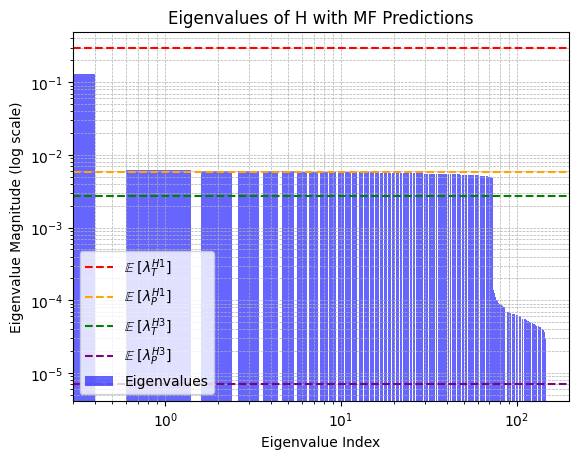

In [27]:
left_eigenvalues_np = left_eigenvalues.detach().cpu().numpy()
sorted_left_eigenvalues = np.sort(left_eigenvalues_np)[::-1]
MF_eigenvalues= experimentMF.predictions
plt.bar(np.arange(len(sorted_left_eigenvalues)), sorted_left_eigenvalues, color='blue', alpha=0.6, label='Eigenvalues')  
plt.axhline(y=MF_eigenvalues.lH1T, color='red', linestyle='--', label='$\mathbb{E}\;[\lambda^{H1}_T]$')
plt.axhline(y=MF_eigenvalues.lH1P, color='orange', linestyle='--', label='$\mathbb{E}\;[\lambda^{H1}_P]$')
plt.axhline(y=MF_eigenvalues.lH3T, color='green', linestyle='--', label='$\mathbb{E}\;[\lambda^{H3}_T]$')
plt.axhline(y=MF_eigenvalues.lH3P, color='purple', linestyle='--', label='$\mathbb{E}\;[\lambda^{H3}_P]$')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue Magnitude (log scale)')
plt.title('Eigenvalues of H with MF Predictions')
plt.legend()
plt.grid(True, which='both', ls='--', lw=0.5)
plt.show()

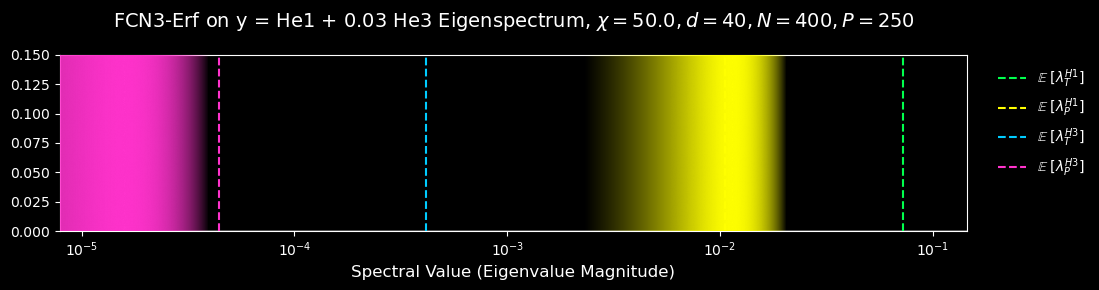

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.colors import LinearSegmentedColormap

# ------------------------------------------------------------------
# 1. Glowy neon colors (RGBA)
# ------------------------------------------------------------------
glow_colors = [
    (0.0, 1.0, 0.3, 1.0),   # Neon green
    (1.0, 1.0, 0.0, 1.0),   # Neon yellow
    (0.0, 0.8, 1.0, 1.0),   # Neon cyan
    (1.0, 0.2, 0.8, 1.0)    # Neon magenta
]

# ------------------------------------------------------------------
# 2. Move ls3 to CPU and convert to NumPy
# ------------------------------------------------------------------
ls3 = ls
ls3_np = ls3.detach().cpu().numpy()

# ------------------------------------------------------------------
# 3. Masks
# ------------------------------------------------------------------
idx_big_np = (ls3_np > 0.1)
idx_mid_np = (ls3_np <= 0.1) & (ls3_np > 1e-3)
idx_small_np = (ls3_np <= 1e-4)

vals_big = ls3_np[idx_big_np]
vals_mid = ls3_np[idx_mid_np]
vals_small = ls3_np[idx_small_np]
vals_h3t = vals_small[:1] if len(vals_small) > 0 else np.array([])
vals_h3p = vals_small[1:] if len(vals_small) > 1 else np.array([])

groups = [
    (vals_big, glow_colors[0], '$\lambda^{H1}_T$'),
    (vals_mid, glow_colors[1], '$\lambda^{H1}_P$'),
    (vals_h3t, glow_colors[2], '$\lambda^{H3}_T$'),
    (vals_h3p, glow_colors[3], '$\lambda^{H3}_P$')
]

# ------------------------------------------------------------------
# 4. Compute mean and std for each group
# ------------------------------------------------------------------
means, stds, labels, colors = [], [], [], []
for vals, color, label in groups:
    if len(vals) > 0:
        mean_val = np.mean(vals)
        std_val = np.std(vals) if len(vals) > 1 else 0.0
        if std_val == 0:
            std_val = 1e-10  # avoid zero-width
        means.append(mean_val)
        stds.append(std_val)
        labels.append(label)
        colors.append(color)

# ------------------------------------------------------------------
# 5. Create figure with black background
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(11, 3))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Horizontal baseline
ax.axhline(y=0, color='gray', linewidth=1.2, alpha=0.7)

height = 0.15  # Short lines for spectral feel

# ------------------------------------------------------------------
# 6. Plot spectral spread: flat height, alpha fade over ±1σ
# ------------------------------------------------------------------
for mean, std, color, label in zip(means, stds, colors, labels):
    if std == 0:
        ax.vlines(mean, 0, height, colors=color, linewidth=3, label=label, zorder=5)
        continue

    # Create 1D gradient: full alpha at center, fade to 0 at edges
    n = 256
    gradient = np.linspace(0, 1, n)
    alpha = np.abs(gradient - 0.5) * 2  # 1 at center, 0 at edges
    alpha = 1 - alpha**2  # smoother fade
    alpha = np.clip(alpha, 0, 1)

    # Build RGBA image: [1, n, 4]
    rgba = np.zeros((1, n, 4))
    rgba[0, :, 0] = color[0]  # R
    rgba[0, :, 1] = color[1]  # G
    rgba[0, :, 2] = color[2]  # B
    rgba[0, :, 3] = alpha     # A

    # Extent: [left, right, bottom, top]
    left = mean - std
    right = mean + std
    extent = [left, right, 0, height]

    ax.imshow(rgba, extent=extent, aspect='auto', origin='lower', interpolation='bicubic', zorder=3)

# ------------------------------------------------------------------
# 7. Overlay expected values as sharp solid lines
# ------------------------------------------------------------------
expected_lines = [
    (MF_eigenvalues.lH1T, glow_colors[0], '$\mathbb{E}\;[\lambda^{H1}_T]$'),
    (MF_eigenvalues.lH1P, glow_colors[1], '$\mathbb{E}\;[\lambda^{H1}_P]$'),
    (MF_eigenvalues.lH3T, glow_colors[2], '$\mathbb{E}\;[\lambda^{H3}_T]$'),
    (MF_eigenvalues.lH3P, glow_colors[3], '$\mathbb{E}\;[\lambda^{H3}_P]$'),
]

for val, color, label in expected_lines:
    ax.vlines(val, 0, height, colors=color, linestyles='--', linewidth=1.5, label=label, zorder=10)

# ------------------------------------------------------------------
# 8. Finalize – clean spectral look
# ------------------------------------------------------------------
plt.xscale('log')
ax.set_xlabel("Spectral Value (Eigenvalue Magnitude)", color='white', fontsize=12)
ax.set_title(f"FCN3-Erf on y = He1 + 0.03 He3 Eigenspectrum, $\\chi={experimentMF.chi: 0.1f},d={experimentMF.d}, N={experimentMF.N}, P={experimentMF.P}$", color='white', fontsize=14, pad=20)

# Ticks and spines
ax.tick_params(axis='both', colors='white', labelsize=10)
for spine in ax.spines.values():
    spine.set_color('white')

# X limits
all_vals = means + [v for v, _, _ in expected_lines]
if all_vals:
    xmin = max(1e-10, min(all_vals) * 0.5)
    xmax = max(all_vals) * 2.0
    plt.xlim(xmin, xmax)

plt.ylim(0, height)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', labelcolor='white', frameon=False, fontsize=10)
plt.tight_layout()
plt.show()

In [55]:
sorted_left_eigenvalues[0] * 3

0.3631747751032451

In [39]:
eig, std = experimentMF.model.H_eig(X, Y1, std=True)
eig = eig.detach().cpu().numpy() 
eig

array([0.12105826, 0.01820733, 0.01475836, 0.01804221, 0.01675018,
       0.01504172, 0.01397929, 0.01635282, 0.01672705, 0.01598615,
       0.01531204, 0.01682266, 0.01540553, 0.0209356 , 0.01918895,
       0.01539665, 0.01681825, 0.01919697, 0.0167039 , 0.01578162,
       0.01584324, 0.01455769, 0.01640668, 0.01609435, 0.01726437])

In [100]:
lH_eigenvalue_normalization = (experimentMF.predictions.lH1P*(experimentMF.d -1) + experimentMF.predictions.lH1T)
experimentMF.predictions.lH1T / lH_eigenvalue_normalization

0.48355152401663504

In [99]:
experimentMF.predictions.lH1P / lH_eigenvalue_normalization

0.021518686499306872

In [104]:
experimentMF.model.H_eig(X, Y1) [:25]

tensor([0.1211, 0.0182, 0.0148, 0.0180, 0.0168, 0.0150, 0.0140, 0.0164, 0.0167,
        0.0160, 0.0153, 0.0168, 0.0154, 0.0209, 0.0192, 0.0154, 0.0168, 0.0192,
        0.0167, 0.0158, 0.0158, 0.0146, 0.0164, 0.0161, 0.0173],
       device='cuda:1')

In [2]:
import juliacall

/home/akiva/miniconda3/envs/ml_env/lib/python3.14/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(
ERROR: ArgumentError: Package PythonCall [6099a3de-0909-46bc-b1f4-468b9a2dfc0d] is required but does not seem to be installed:
 - Run `Pkg.instantiate()` to install all recorded dependencies.

Stacktrace:
 [1] __require_prelocked(pkg::Base.PkgId, env::String)
   @ Base ./loading.jl:2612
 [2] _require_prelocked(uuidkey::Base.PkgId, env::String)
   @ Base ./loading.jl:2490
 [3] macro expansion
   @ ./loading.jl:2418 [inlined]
 [4] macro expansion
   @ ./lock.jl:376 [inlined]
 [5] __require(into::Module, mod::Symbol)
   @ Base ./loading.jl:2383
 [6] require(into::Module, mod::Symbol)
   @ Base ./loading.jl:2359
 [7] top-level scope
   @ none:8

Exception: PythonCall.jl did not start properly

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
%load_ext autoreload
%autoreload 2
import sys
import scipy.stats as stats
sys.path.insert(0, '/home/akiva/FCNX-Ensembling/lib')
from Experiment import Experiment 


/home/akiva/miniconda3/envs/ml_env/lib/python3.12/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:51: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:51: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_344478/4087406272.py:48: SyntaxWarning: invalid escape sequence '\m'
  plt.axhline(y=MF_eigenvalues.lH1T, color='red', linestyle='--', label='$\mathbb{E}\;[\lambda^{H1}_T]$')
/tmp/ipykernel_344478/4087406272.py:49: SyntaxWarning: invalid escape sequence '\m'
  plt.axhline(y=MF_eigenvalues.lH1P, color='orange', linestyle='--', label='$\mathbb{E}\;[\lambda^{H1}_P]$')
/tmp/ipykernel_344478/4087406272.py:50: SyntaxWarning: invalid escape sequence '\m'
  plt.axhline(y=MF_eigenvalues.lH3T, color='green', linestyle='--', label='$\mathbb{E}\;[\lambda^{H3}_T]$')
/tmp/ipykernel_34

Loaded model state_dict from /home/akiva/exp/d_sweep_fcn3_PNd_dsavg/erf_cubic_eps_0.03_P_300_D_60_N_240_epochs_5000000_lr_1.50e-05/model.pth
Model device is:  cuda:0
Available memory: 46.10 GB
Free memory: 28.46 GB
Computing H_random_QB on device:  cuda:0
Computing H_random_QB on device:  cuda:0
[Random Omega generation] 0.0000s
[  res chunk [0:4096]] 0.0009s
[  res chunk [4096:5000]] 0.0006s
[res computation (chunks of 4096)] 0.0030s
[QR factorisation] 0.0303s
[  Z chunk [0:4096]] 0.0027s
[  Z chunk [4096:5000]] 0.0006s
[Z computation (chunks of 4096)] 0.0067s
[Random Omega generation] 0.0000s
[  res chunk [0:4096]] 0.0008s
[  res chunk [4096:5000]] 0.0005s
[res computation (chunks of 4096)] 0.0022s
[QR factorisation] 0.0294s
[  Z chunk [0:4096]] 0.0026s
[  Z chunk [4096:5000]] 0.0006s
[Z computation (chunks of 4096)] 0.0062s
[B = Q.T @ Z] 0.0006s
[eigvalsh] 0.0288s
[final sort] 0.0014s


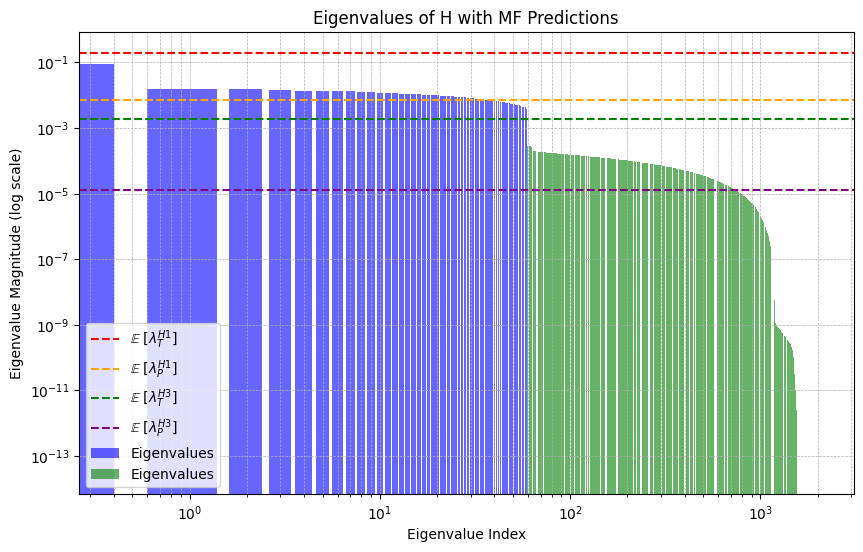

In [49]:


experimentMF = Experiment(
        eps=0.03,
        file = '/home/akiva/exp/d_sweep_fcn3_PNd_dsavg/erf_cubic_eps_0.03_P_300_D_60_N_240_epochs_5000000_lr_1.50e-05',
        N=240,
        d=60,
        chi=240/2,
        P=300,
        ens=5,
        kappa = 1.0,
        device = torch.device('cuda:0')
    )

experimentMF.load()
experimentMF.model.to(experimentMF.device)
experimentMF.predictions = experimentMF.eig_predictions()
X, Y1,Y3 = experimentMF.large_dataset(p_large = 5000, flat=True)
experimentMF.model.device = experimentMF.device
print("Model device is: ", experimentMF.model.device)
# Available CPU memory:
import psutil
mem = psutil.virtual_memory()
print(f"Available memory: {mem.available / (1024**3):.2f} GB")
# Available memory not in use:
print(f"Free memory: {mem.free / (1024**3):.2f} GB")
# compute the svd of the low rank approximaton to H
# Random svd goes from H ∈ ℝ^m*m to its low rank approximation QB ∈ ℝ^m*m with Q ∈ ℝ^m*l and B ∈ ℝ^l*k. 
Q, Z = experimentMF.model.H_random_QB(X, k = 2000, p=200)
Ut, _S, V = torch.linalg.svd(Z.T)
m, n = Z.shape[1], Z.shape[0]
k = min(m, n)
Sigma = torch.zeros(m, n, device=Z.device, dtype=Z.dtype)
Sigma[:k, :k] = torch.diag(_S) 
U = torch.matmul(Q, Ut)
ls = Sigma.diagonal() / X.shape[0]
Y1 = Y1 / torch.norm(Y1, dim=0) 
Y3 = Y3 / torch.norm(Y3, dim=0)
Y1_sandwich = (torch.matmul(Y1.t(), U) @ _S.diag() @ torch.matmul(U.T, Y1)).diagonal() / X.shape[0]
Y3_sandwich = (torch.matmul(Y3.t(), U) @ _S.diag() @ torch.matmul(U.T, Y3)).diagonal()  / X.shape[0]
left_eigenvalues = torch.cat([Y1_sandwich, Y3_sandwich], dim=0)
# Bar plot of all eigenvalues and horizontal lines for all the predictions
plt.figure(figsize=(10, 6))
left_eigenvalues_np = left_eigenvalues.detach().cpu().numpy() 
left_eigenvalues_np = experimentMF.model.H_eig_random_svd(X, k=2000).detach().cpu().numpy()
sorted_left_eigenvalues = np.sort(left_eigenvalues_np)[::-1]
MF_eigenvalues= experimentMF.predictions
plt.bar(np.arange(len(sorted_left_eigenvalues[:experimentMF.d])), sorted_left_eigenvalues[:experimentMF.d], color='blue', alpha=0.6, label='Eigenvalues')  
plt.bar(np.arange(experimentMF.d,experimentMF.d + len(sorted_left_eigenvalues[experimentMF.d:])), sorted_left_eigenvalues[experimentMF.d:], color='green', alpha=0.6, label='Eigenvalues')  
plt.axhline(y=MF_eigenvalues.lH1T, color='red', linestyle='--', label='$\mathbb{E}\;[\lambda^{H1}_T]$')
plt.axhline(y=MF_eigenvalues.lH1P, color='orange', linestyle='--', label='$\mathbb{E}\;[\lambda^{H1}_P]$')
plt.axhline(y=MF_eigenvalues.lH3T, color='green', linestyle='--', label='$\mathbb{E}\;[\lambda^{H3}_T]$')
plt.axhline(y=MF_eigenvalues.lH3P, color='purple', linestyle='--', label='$\mathbb{E}\;[\lambda^{H3}_P]$')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue Magnitude (log scale)')
plt.title('Eigenvalues of H with MF Predictions')
plt.legend()
plt.grid(True, which='both', ls='--', lw=0.5)
plt.show()

In [18]:
torch.norm(Y1, dim=0)

tensor([55.1535, 56.0261, 53.9554, 55.7111, 54.6099, 54.0654, 54.2988, 56.0153,
        53.7719, 54.4736, 55.4694, 54.7229, 55.0195], device='cuda:0')